<a name="home"></a>
## Table of Contents

1. [Importing libraries](#Imports)
2. [Metric Generation](#Metrics)
3. [Generating Images from the different CCELD Steps for Paper](#Gen_images)

## MY VERY OWN APPROACH TO SEGMENTATION. OPTIONAL BRIGHTENING
I will most likely compare this with segformer and UNETs output. I'll also use this as a preprocessing technique before passing into the classification models.

Drawbacks
1. It doesn't capture widths, like thick cracks, it doesn't capture the entire thickness. That's the next point for improvement.

Trials
1. Try Sqauring the absolute difference to see if the noise will vanish as compared to the actual cracks

## Important notes.
1. I've seen that I need to create a technique that does well with different colors in image (contrast enhancement works)
2. Does automated Kernel shape selection later (for now, since my cracks will be more or less the same, a moderately large kernel is enough.
3. Handles noise well.

## The positive formula brings about the extra white pixel issue. I'll be tuning the negative for now
<a name="Imports"></a>

In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from empiricaldist import Cdf
import sys
import os
import itertools
import ast

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score

from tqdm import tqdm

In [6]:
# Load the image
#image = cv2.imread('image.jpg')
path = 'Manual_Segmentation/Images_and_Masks/Most_Recent_Images_and_Masks/'
#image= cv2.imread(path+'Original_Images/Img_37.jpg')
image=cv2.imread('7024-145_flip_hflip.jpg')

# Convert the images to grayscale
gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

# Smooth the image to remove noise
smooth_image = cv2.blur(gray_image, (3, 3))

# Resizing both images
gray_image = cv2.resize(gray_image, (400, 400))
print(gray_image.dtype)
print(np.min(gray_image),np.max(gray_image))
      
# applying contrast and brightness enhancement
alpha = 1 # Simple contrast control
beta = 50   # Simple brightness control   
gray_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)
print(gray_image.dtype)
print(np.min(gray_image),np.max(gray_image))
plt.imshow()

'''
# Calculate the mean and standard deviation of the pixel values using a 3x3 neighborhood
mean_image = cv2.blur(gray_image, (31, 31))

gray_image = gray_image.astype(np.int32)
mean_image = mean_image.astype(np.int32)

std_image = gray_image - mean_image

# Automated threshold selection based on histogram distribution in gray image, basically if there's so much brightness in
# image we want to use a high threshold to activate the crack if not, we use a low threshold

# Calculating the average of the 25th, 50th, 75th, and 85th percentile pixel value
perc_25, perc_35, perc_45, perc_50, perc_65, perc_75  = np.percentile(smooth_image, 25), np.percentile(smooth_image, 35), \
np.percentile(smooth_image, 45), np.percentile(smooth_image, 50), np.percentile(smooth_image, 65), np.percentile(smooth_image, 75)

# Calculating average of the 1th, 1.2th and 1.5th percentiles
perc_1, perc_1p2, perc_1p5 = np.percentile(smooth_image, 1), np.percentile(smooth_image, 1.2), \
np.percentile(smooth_image, 1.5)

low_mean = np.mean([perc_1, perc_1p2, perc_1p5])
high_mean = np.mean([perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
join_mean = np.mean([perc_1, perc_1p2, perc_1p5, perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])

diff = high_mean - low_mean
threshold = join_mean - low_mean
#ratio = low_mean/high_mean

threshold = (np.sqrt(threshold)/0.4)*-1
# print(threshold)
print('Your threshold is {}'.format(threshold))

# Create a binary mask where cracks are represented as white pixels
crack_mask = np.zeros_like(std_image)
crack_mask[std_image <= threshold] = 255

# Apply the crack mask to the original image
gray_image = gray_image.astype(np.uint8)
crack_mask = crack_mask.astype(np.uint8)
#crack_mask = cv2.bilateralFilter(crack_mask,9,75,75)
#segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=crack_mask)
plt.imshow(crack_mask, cmap='gray')
plt.grid()
#plt.savefig('third.jpg', dpi=800, bbox_inches='tight')

## Implementing SKELE MARKER METHOD
# Step 1. Area Thresholding
np.unique(crack_mask)

# Display the segmented image
#cv2.imshow('Segmented Image', segmented_image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()'''

uint8
31 217
uint8
81 255


"\n# Calculate the mean and standard deviation of the pixel values using a 3x3 neighborhood\nmean_image = cv2.blur(gray_image, (31, 31))\n\ngray_image = gray_image.astype(np.int32)\nmean_image = mean_image.astype(np.int32)\n\nstd_image = gray_image - mean_image\n\n# Automated threshold selection based on histogram distribution in gray image, basically if there's so much brightness in\n# image we want to use a high threshold to activate the crack if not, we use a low threshold\n\n# Calculating the average of the 25th, 50th, 75th, and 85th percentile pixel value\nperc_25, perc_35, perc_45, perc_50, perc_65, perc_75  = np.percentile(smooth_image, 25), np.percentile(smooth_image, 35), np.percentile(smooth_image, 45), np.percentile(smooth_image, 50), np.percentile(smooth_image, 65), np.percentile(smooth_image, 75)\n\n# Calculating average of the 1th, 1.2th and 1.5th percentiles\nperc_1, perc_1p2, perc_1p5 = np.percentile(smooth_image, 1), np.percentile(smooth_image, 1.2), np.percentile(smoo

## Conected Component Analysis
What's happening is that each connected noise is assigned a label and basically a crack should have a long length of connected white pixels so what that means is that the crack gets just one label and when the area which is a sum of all those pixels are gotten, it will be large for cracks and smaller for non cracks.

Issues
1. How to know if it'll be small or large noise in your Image?
2. I could actually set a high area and it should yield good results for my dataset since my crack are wide and connected but If cracks are also thin and not very connected, a high area will remove cracks. 
3. 

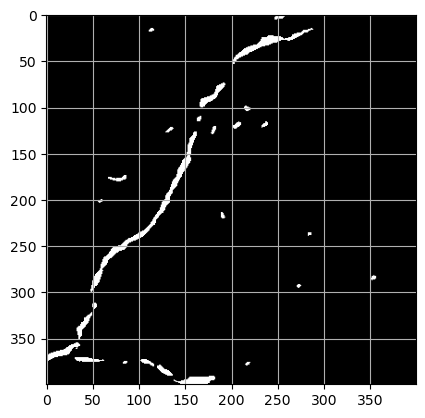

In [97]:
# Find connected components and their stats (including area)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(crack_mask, connectivity=8)

# Define a minimum area threshold to remove small objects (adjust this value as needed)
min_area_threshold = 12  # Adjust this threshold as needed

# Create a mask to store the selected components
selected_components = np.zeros_like(crack_mask)

# Iterate through connected components
for label in range(1, num_labels):
    # Check the area of the current component
    area = stats[label, cv2.CC_STAT_AREA]
    #print(area)
    
    # If the area is greater than or equal to the threshold, include it in the selected components
    if area >= min_area_threshold:
        selected_components[labels == label] = 255  # Set pixels to 255 (white)

plt.imshow(selected_components, cmap='gray')
plt.grid()

In [98]:
# Step 5: Length Threshold
def remove_small_skeletons(thinned_image, Tlength):
    # Labels is the image with each pixel assigned a label after the connected component analysis has been done
    _, labels = cv2.connectedComponents(thinned_image)
    
    # The number of labels is max label + 1 since we do 0 indexing
    num_labels = labels.max() + 1
    
    # We create a list to store the skeletons or say the skeleton images where the >= Tlength condition is satisfied
    skeletons = []

    for label in range(1, num_labels):  # Exclude background (label 0)
        # We loop through all the labels and the variable "component" just creates an image where only pixels from a 
        # Particular label is shown
        component = (labels == label).astype(np.uint8)
        #print(component.shape)
        
        # Below after getting all pixels from each label, we sum the pixels from the labels and use basically if the sum 
        # of the skeleton from a particular label is small, we take it as noise which makes a whole lot of sense.
        if np.sum(component) >= Tlength:
            skeletons.append(component)

    # Create a new thinned image with the remaining skeletons - we basically join all the skeletons in the skeleton list
    # The skeleton list is where we kept the pixels with long lengths
    thinned_image = np.zeros_like(thinned_image)
    for skeleton in skeletons:
        thinned_image |= skeleton  # Use logical OR to combine skeletons

    return thinned_image

def restore_skeletons(original_image, thinned_image, Tradius):
    endpoints = cv2.findNonZero(cv2.bitwise_and(thinned_image, cv2.dilate(thinned_image, None)))
    
    if endpoints is not None:
        for endpoint in endpoints:
            x, y = endpoint[0][0], endpoint[0][1]  # Corrected indices for x and y
            mask = np.zeros_like(original_image)
            cv2.circle(mask, (x, y), Tradius, 255, -1)

            # Restore pixels in the thinned image using the mask
            thinned_image = np.maximum(thinned_image, cv2.bitwise_and(original_image, mask))

    return thinned_image


# Load your binary crack image
image = selected_components

# Define parameters
Tlength = 31  # Adjust this threshold as needed
Tradius = 18  # Adjust the radius as needed

# Thinning using Zhang-Suen algorithm
thinned_image = cv2.ximgproc.thinning(image)

# Step 5: Remove small skeletons
thinned_image = remove_small_skeletons(thinned_image, Tlength)

# Step 6: Restore skeletons
restored_image = imreconstruct(thinned_image, image, 1)

# Save or display the final restored image
plt.imshow(restored_image, cmap='gray')


NameError: name 'imreconstruct' is not defined

In [ ]:
plt.imshow(thinned_image, cmap='gray')

In [21]:
def find_endpoints(thinned_image):
    endpoints = []
    height, width = thinned_image.shape

    # We loop from (1,1) so that each pixel will have eight neighbours (0,0) is the edge
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            if thinned_image[x, y] == 1:  # Check if it's a white pixel (part of skeleton)
                # Define a neighborhood of 8 pixels around the current pixel
                neighborhood = thinned_image[x-1:x+2, y-1:y+2]

                # Count the number of non-zero (white) pixels in the neighborhood
                white_pixel_count = np.count_nonzero(neighborhood)
                #print(white_pixel_count)

                # If there's only one white pixel in the neighborhood, it's an endpoint
                if white_pixel_count == 2:#
                    endpoints.append((x, y))
    return endpoints

# Example usage:
endpoints = find_endpoints(thinned_image)


# 'endpoints' is a list of (x, y) coordinates where endpoints are detected
print("Detected Endpoints:", endpoints)


Detected Endpoints: [(5, 257), (11, 240), (11, 306), (52, 203), (63, 199), (96, 169), (128, 161), (165, 84), (178, 66), (277, 24), (280, 26), (282, 31), (282, 42), (295, 239), (301, 48), (302, 227), (303, 231), (314, 52), (319, 184), (325, 197), (370, 27), (370, 126), (373, 70), (375, 78), (375, 221), (384, 194), (388, 145), (392, 181), (396, 138)]


In [33]:
thinned_image[4:7,256:259]

array([[0, 0, 0],
       [1, 1, 0],
       [0, 0, 0]], dtype=uint8)

## Functions

In [226]:
def apply_area_thresholding(crack_mask, Tarea=10):
    # Find connected components and their stats (including area)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(crack_mask, connectivity=8)

    # Define a minimum area threshold to remove small objects (adjust this value as needed)
    min_area_threshold = Tarea  # Adjust this threshold as needed

    # Create a mask to store the selected components
    selected_components = np.zeros_like(crack_mask)

    # Iterate through connected components
    for label in range(1, num_labels):
        # Check the area of the current component
        area = stats[label, cv2.CC_STAT_AREA]
        #print(area)

        # If the area is greater than or equal to the threshold, include it in the selected components
        if area >= min_area_threshold:
            selected_components[labels == label] = 255  # Set pixels to 255 (white)

    return selected_components

def get_circle(tlength_applied_thin_img, original_image, Tradius= 20):   
    endpoints = find_endpoints(tlength_applied_thin_img)
    #print(endpoints)
    mask = np.zeros_like(original_image)
    for endpoint in endpoints:
        x, y = endpoint[1], endpoint[0]
        #mask = np.zeros_like(original_image)
        cv2.circle(mask, (x, y), Tradius, 255, -1)
        mask = cv2.bitwise_or(mask, mask)
    return mask

In [160]:
def find_endpoints(thinned_image):
    endpoints = []
    height, width = thinned_image.shape

    # We loop from (1,1) so that each pixel will have eight neighbours (0,0) is the edge
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            if thinned_image[x, y] == 1:  # Check if it's a white pixel (part of skeleton)
                # Define a neighborhood of 8 pixels around the current pixel
                neighborhood = thinned_image[x-1:x+2, y-1:y+2]

                # Count the number of non-zero (white) pixels in the neighborhood
                white_pixel_count = np.count_nonzero(neighborhood)
                #print(white_pixel_count)

                # If there's only one white pixel in the neighborhood, it's an endpoint
                if white_pixel_count == 2:#
                    endpoints.append((x, y))
    return endpoints

# Step 5: Length Threshold
def remove_small_skeletons(thinned_image, Tlength): 
    _, labels = cv2.connectedComponents(thinned_image)
    
    # The number of labels is max label + 1 since we do 0 indexing
    num_labels = labels.max() + 1
    
    # We create a list to store the skeletons or say the skeleton images where the >= Tlength condition is satisfied
    skeletons = []

    for label in range(1, num_labels):  # Exclude background (label 0)
        # We loop through all the labels and the variable "component" just creates an image where only pixels from a 
        # Particular label is shown
        component = (labels == label).astype(np.uint8)
        #print(component.shape)
        
        
        # Below after getting all pixels from each label, we sum the pixels from the labels and use basically if the sum 
        # of the skeleton from a particular label is small, we take it as noise which makes a whole lot of sense.
        if np.sum(component) >= Tlength:
            skeletons.append(component)

    # Create a new thinned image with the remaining skeletons - we basically join all the skeletons in the skeleton list
    # The skeleton list is where we kept the pixels with long lengths
    thinned_image = np.zeros_like(thinned_image)
    for skeleton in skeletons:
        thinned_image |= skeleton  # Use logical OR to combine skeletons

    return thinned_image

def implement_radius_restoration(tlength_applied_thin_img, original_image, Tradius= 20):   
    endpoints = find_endpoints(tlength_applied_thin_img)
    #print(endpoints)

    for endpoint in endpoints:
        x, y = endpoint[1], endpoint[0]
        mask = np.zeros_like(original_image)
        cv2.circle(mask, (x, y), Tradius, 255, -1)
        #plt.imshow(mask, cmap='gray')
        #plt.show()
    # Restore pixels in the thinned image using the mask
        tlength_applied_thin_img = np.maximum(tlength_applied_thin_img, cv2.bitwise_and(original_image, mask)) 
        
    return tlength_applied_thin_img

# Basically, this part is to restore the skeletons based after using tlength to remove stuff. The idea is to use dilation with
# a kernel which tells how much pixels to add basically to grow back pixels in the skeleton from the original image. 
# We then use bitwise and which returns 1 if both pictures are 1 and 1. What we're doing is that with dilation, 
# we're growing pixels but we want to keep only pixels based on their presence in out dirty image.
def restore_skeletons(original_image, thinned_image, radius = 1):   
    # Dilation process
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    
    # Here, we're basically doing dilation on the thinned image after that, we do the bitwise and on the dilated result and mask
    # and update the variable "expanded", thinned image on first iteration is still the skeleton but then we check if the 
    # thinned image == expanded(i.e dilated+mask) we then update thinned to be = expanded. We do a dilation on the new updated
    # thinned which takes the variable expanded, we then use bitwise_and on dilation 2 and original image and update expanded.
    # Now, thinned is first comparison of dilation and mask the idea is we want to stop when the result of a previous 
    # dilation and mask operation if it's the same as the current dilation and mask bitwise operation
    while True:
        expanded = cv2.dilate(src=thinned_image, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=original_image, dst=expanded)

        # Termination criterion: Expansion didn't change the image at all
        if (thinned_image == expanded).all():
            return expanded
        thinned_image = expanded
        
def get_metrics(y_true, y_pred):
    return f1_score(y_true, y_pred), recall_score(y_true, y_pred), precision_score(y_true, y_pred, zero_division=0), accuracy_score(y_true, y_pred), jaccard_score(y_true, y_pred)

In [123]:
def Pipeline (image_name, mask_name, kernel = (31,31), div=0.4, Tarea = 12, Tlength = 43, Tradius = 18):
    '''Displays Gound truth and CCELD Predicted mask based on Specified Kernel'''
    # Reading Images
    path = 'Manual_Segmentation/Images_and_Masks/Segmentation_test/'
    image= cv2.imread(path+'Seg_test_Images/'+image_name)
    groud_truth = cv2.imread(path+'/Seg_test_Masks/'+mask_name)
    
    # Convert the images to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    groud_truth_img = cv2.cvtColor(np.array(groud_truth), cv2.COLOR_BGR2GRAY)
    
    # Smooth the image to remove noise
    smooth_image = cv2.blur(gray_image, (3, 3))
    
    # Resizing both images
    gray_image = cv2.resize(smooth_image, (400, 400))
    groud_truth_img = cv2.resize(groud_truth_img, (400, 400))
    
    # Ground truth image has some Issues at the edge so, we have to apply a simple thresholding
    groud_truth_img = np.where(groud_truth_img<90, 0, groud_truth_img)
    groud_truth_img = np.where(groud_truth_img>=90, 255, groud_truth_img)

    # applying contrast and brightness enhancement
    alpha = 1 # Simple contrast control
    beta = 50   # Simple brightness control   
    gray_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    # Calculate the mean and standard deviation of the pixel values using a 3x3 neighborhood
    mean_image = cv2.blur(gray_image, kernel)

    gray_image = gray_image.astype(np.int32)
    mean_image = mean_image.astype(np.int32)

    std_image = gray_image - mean_image

    # Automated threshold selection based on histogram distribution in gray image, basically if there's so much brightness in
    # image we want to use a high threshold to activate the crack if not, we use a low threshold

    # Calculating the average of the 25th, 50th, 75th, and 85th percentile pixel value
    perc_25, perc_35, perc_45, perc_50, perc_65, perc_75  = np.percentile(smooth_image, 25), np.percentile(smooth_image, 35), \
    np.percentile(smooth_image, 45), np.percentile(smooth_image, 50), np.percentile(smooth_image, 65), np.percentile(smooth_image, 75)

    # Calculating average of the 1th, 1.2th and 1.5th percentiles
    perc_1, perc_1p2, perc_1p5 = np.percentile(smooth_image, 1), np.percentile(smooth_image, 1.2), \
    np.percentile(smooth_image, 1.5)

    low_mean = np.mean([perc_1, perc_1p2, perc_1p5])
    high_mean = np.mean([perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
    join_mean = np.mean([perc_1, perc_1p2, perc_1p5, perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
    
    diff = high_mean - low_mean
    threshold = join_mean - low_mean
    #ratio = low_mean/high_mean
    
    threshold = (np.sqrt(threshold)/div)*-1
    # print(threshold)
    #print('Your threshold is {}'.format(threshold))
    
    # Create a binary mask where cracks are represented as white pixels
    crack_mask = np.zeros_like(std_image)
    crack_mask[std_image <= threshold] = 255

    # Apply the crack mask to the original image
    gray_image = gray_image.astype(np.uint8)
    crack_mask = crack_mask.astype(np.uint8)
    #segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=crack_mask)
    
    # Applying Skele-Marker
    # 1. Area thresholding on crack image
    sk_crack_mask = apply_area_thresholding(crack_mask, Tarea)
    
    # 2. Thinning and using Tlength
    thinned_image = cv2.ximgproc.thinning(sk_crack_mask)
    
    # 3. Remove small skeletons
    thinned_image = remove_small_skeletons(thinned_image, Tlength)

    # 4. Restore skeletons
    restored_image = restore_skeletons(sk_crack_mask, thinned_image)

    # 5. Using Radius restoration
    rad = implement_radius_restoration(thinned_image, sk_crack_mask, Tradius = Tradius)
    
    # Combining remaining skeleton with radius based on endpoint restoration
    sk_crack_mask = cv2.bitwise_or(restored_image*255, rad)
    
    #Applying morphological operations
    #kernel = np.array([[1,1,1], [1,1,1]])
    #erosion = cv2.erode(crack_mask, kernel, iterations=1)
    
    # Calculating IOU score between mask and CCELD segmentation
    truth_label = np.where(groud_truth_img==255, 1, groud_truth_img).flatten()
    cceld_label = np.where(crack_mask==255, 1, crack_mask).flatten()
    sk_crack_mask_label = np.where(sk_crack_mask==255, 1, sk_crack_mask).flatten()
    cceld_skele = np.where(crack_mask==255, 1, crack_mask).flatten()
    jac_cceld = jaccard_score(truth_label, cceld_label)
    jac_cceld_skele = jaccard_score(truth_label, sk_crack_mask_label)
    
    #return truth_label, cceld_label, sk_crack_mask_label
    #jac = jaccard_score(np.where(groud_truth_img==255, 1, groud_truth_img), np.where(crack_mask==255, 1, crack_mask))
    #print('The Intersection over Union Score for Raw CCELD is {} combining with Skele-Marker, it\'s {}'.format(
     #   jac_cceld, jac_cceld_skele))

    # Displaying Results
    plt.figure(figsize=(9,7))
    plt.subplot(1,3,1)
    plt.imshow(groud_truth_img, cmap='gray')
    plt.title('Ground Truth')
    plt.subplot(1,3,2)
    plt.imshow(crack_mask, cmap='gray')
    plt.title('CCELD Mask')
    plt.subplot(1,3,3)
    plt.imshow(sk_crack_mask, cmap='gray')
    plt.title('CCELD + SKELE-MARKER Mask')
    plt.grid()
    plt.show()

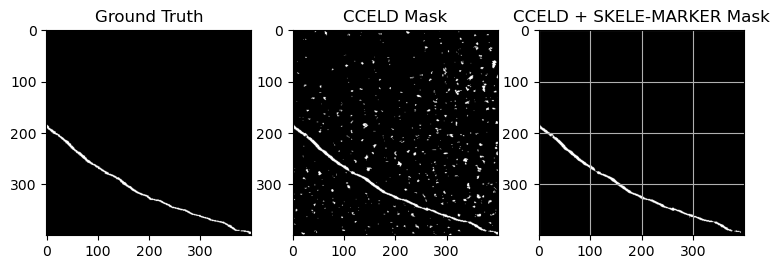

In [116]:
Pipeline('Img_16.jpg', 'Img_16.jpg')

## Analysis with IOU

In [26]:
# Opening the original Images and Masks directories to create list of image names
org_images = os.listdir(path+'Original_Images')

In [27]:
'''# Renaming all files
for ind, img_name in enumerate(org_images):
    old_name = path+'Original_Images/'+img_name
    new_name = path+'Original_Images/'+'Img_'+str(ind+1)+'.jpg'
    os.rename(old_name, new_name)
    print('Renamed {} to {}'.format(img_name, 'Img_'+str(ind+1)+'.jpg'))'''

"# Renaming all files\nfor ind, img_name in enumerate(org_images):\n    old_name = path+'Original_Images/'+img_name\n    new_name = path+'Original_Images/'+'Img_'+str(ind+1)+'.jpg'\n    os.rename(old_name, new_name)\n    print('Renamed {} to {}'.format(img_name, 'Img_'+str(ind+1)+'.jpg'))"

In [1]:
path = 'Manual_Segmentation/Images_and_Masks/Segmentation_test/'
# Opening the original Images and Masks directories to create list of image names
org_images = sorted(os.listdir(path+'Seg_test_Images'))
msk_images = sorted(os.listdir(path+'Seg_test_Masks'))

NameError: name 'os' is not defined

Img_1.jpg
Your threshold is -7.916228058025277
The Intersection over Union Score is 0.0914595949049906


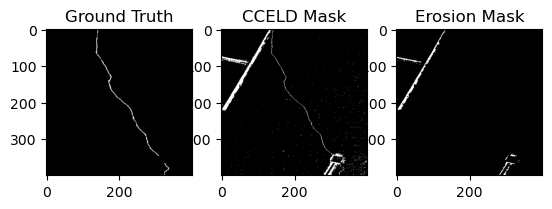

Img_10.jpg
Your threshold is -12.771496040445346
The Intersection over Union Score is 0.24034749034749034


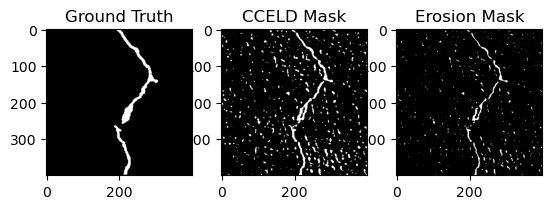

Img_11.jpg
Your threshold is -12.1472447721924
The Intersection over Union Score is 0.2307495085890095


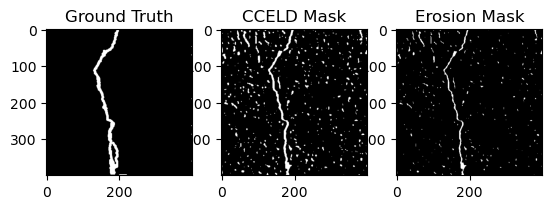

Img_12.jpg
Your threshold is -14.1578403877302
The Intersection over Union Score is 0.23390922925431923


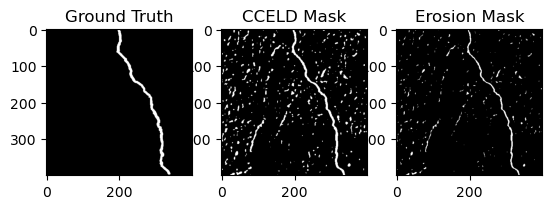

Img_13.jpg
Your threshold is -14.1578403877302
The Intersection over Union Score is 0.2353269463305739


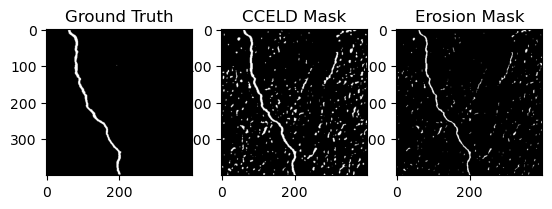

Img_14.jpg
Your threshold is -14.907119849998598
The Intersection over Union Score is 0.30547958125058944


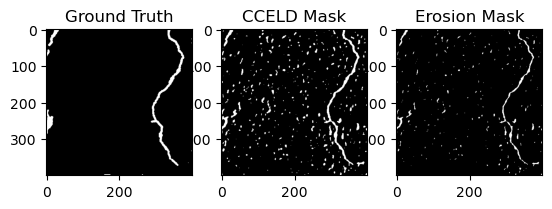

Img_15.jpg
Your threshold is -12.858201014657272
The Intersection over Union Score is 0.282707622298066


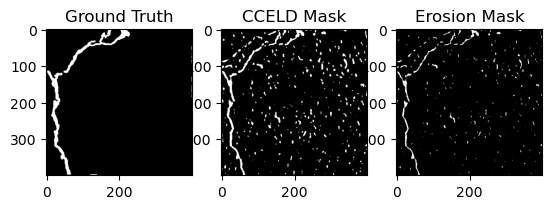

Img_16.jpg
Your threshold is -8.353309390761108
The Intersection over Union Score is 0.08644751124205304


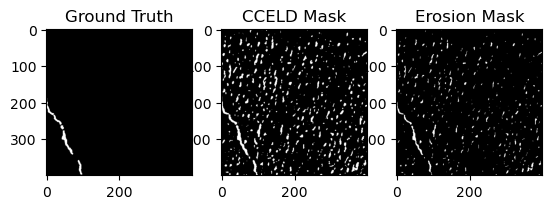

Img_17.jpg
Your threshold is -8.055363982396376
The Intersection over Union Score is 0.08905728020858796


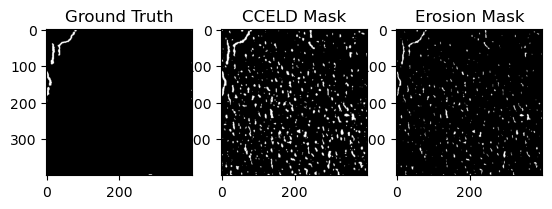

Img_18.jpg
Your threshold is -9.357112565078799
The Intersection over Union Score is 0.26692357096981373


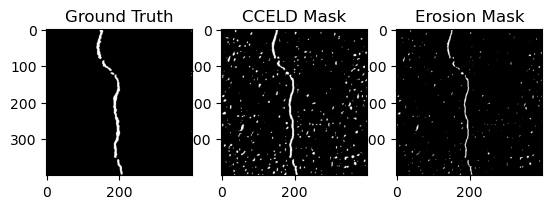

Img_19.jpg
Your threshold is -9.357112565078799
The Intersection over Union Score is 0.2664886515353805


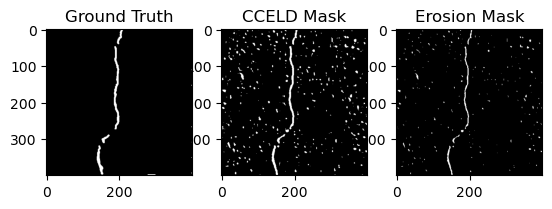

Img_2.jpg
Your threshold is -12.944325225965068
The Intersection over Union Score is 0.29205696443530577


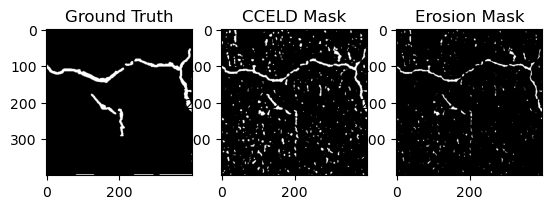

Img_20.jpg
Your threshold is -9.45163125250522
The Intersection over Union Score is 0.26236361782400325


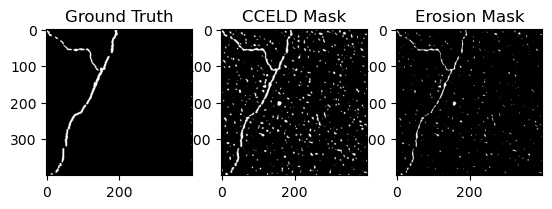

Img_21.jpg
Your threshold is -8.743251365736002
The Intersection over Union Score is 0.32323586061985643


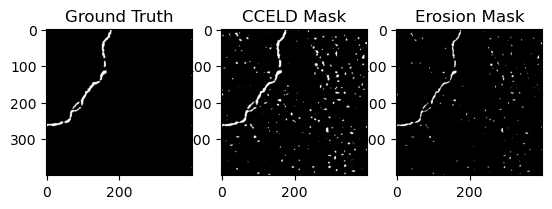

Img_22.jpg
Your threshold is -9.752492558885194
The Intersection over Union Score is 0.08853910477127398


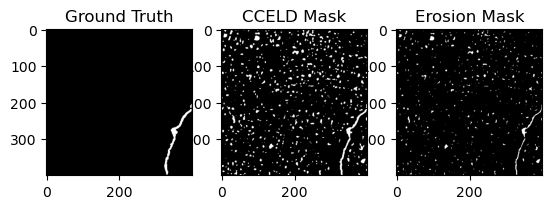

Img_23.jpg
Your threshold is -12.66666666666667
The Intersection over Union Score is 0.18723500908540278


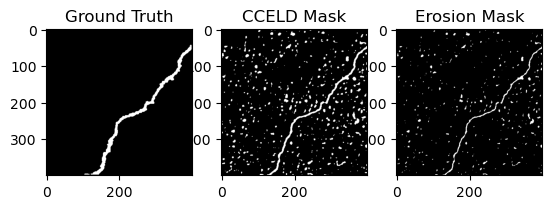

Img_24.jpg
Your threshold is -10.244998779892555
The Intersection over Union Score is 0.22344126304522344


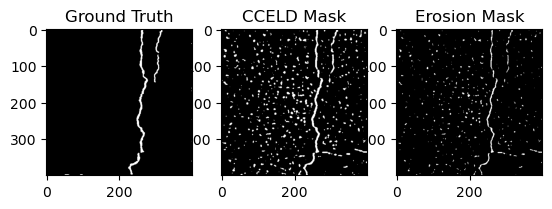

Img_25.jpg
Your threshold is -13.792107243718133
The Intersection over Union Score is 0.19912974683544304


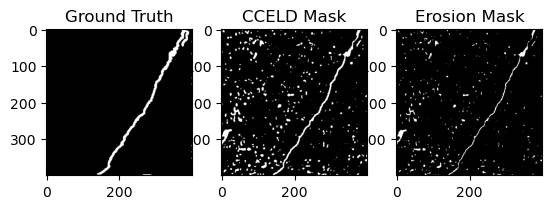

Img_26.jpg
Your threshold is -16.220700080795254
The Intersection over Union Score is 0.38292976881779334


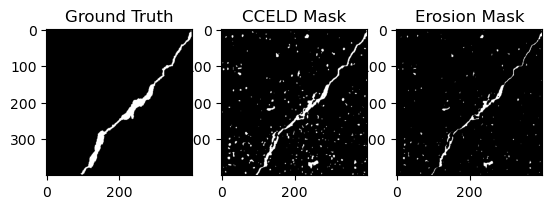

Img_27.jpg
Your threshold is -10.219806477837261
The Intersection over Union Score is 0.13292716698975354


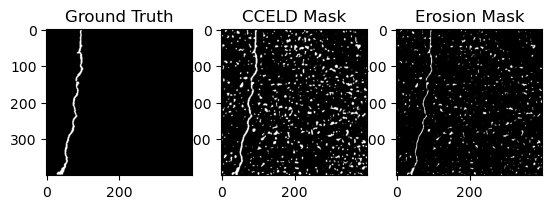

Img_28.jpg
Your threshold is -11.585431464655176
The Intersection over Union Score is 0.1967749856756978


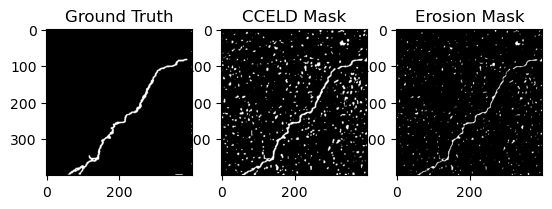

Img_29.jpg
Your threshold is -10.873004286866724
The Intersection over Union Score is 0.21353846153846154


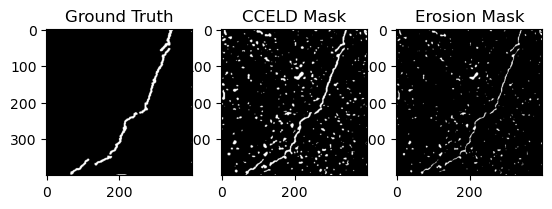

Img_3.jpg
Your threshold is -12.944325225965068
The Intersection over Union Score is 0.2695534276756207


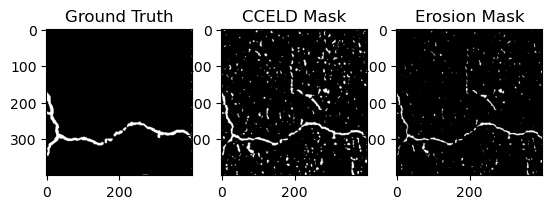

Img_30.jpg
Your threshold is -11.944315244779279
The Intersection over Union Score is 0.1873831395821478


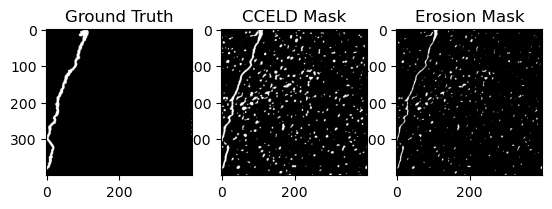

Img_33.jpg
Your threshold is -14.391355429948602
The Intersection over Union Score is 0.03796281830963912


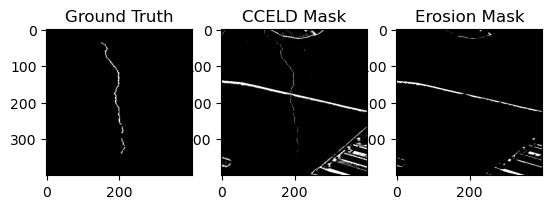

Img_34.jpg
Your threshold is -15.20233900132184
The Intersection over Union Score is 0.5381239714755897


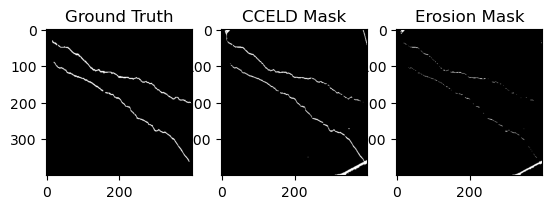

Img_4.jpg
Your threshold is -11.58543146465518
The Intersection over Union Score is 0.23826994990474848


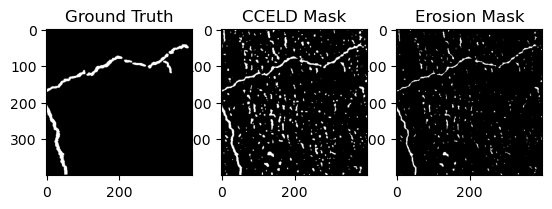

Img_5.jpg
Your threshold is -11.58543146465518
The Intersection over Union Score is 0.23472846765824973


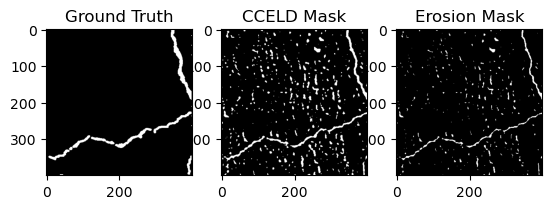

Img_6.jpg
Your threshold is -6.666666666666668
The Intersection over Union Score is 0.09842108496651718


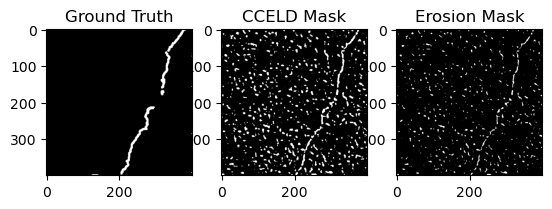

Img_7.jpg
Your threshold is -6.666666666666668
The Intersection over Union Score is 0.09501020929045431


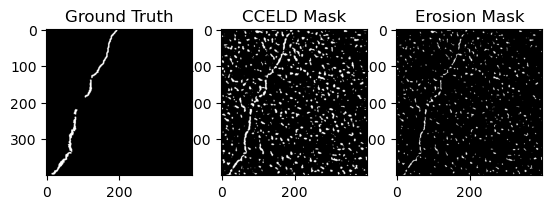

Img_8.jpg
Your threshold is -11.411495179082463
The Intersection over Union Score is 0.17898426430009695


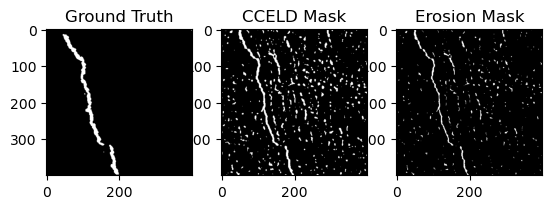

Img_9.jpg
Your threshold is -11.411495179082463
The Intersection over Union Score is 0.1908993411981002


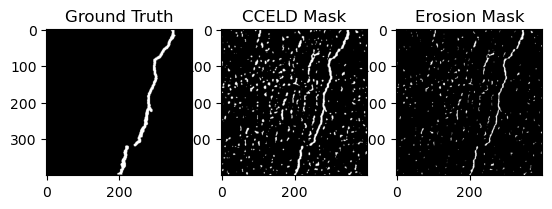

In [29]:
for org, msk in zip(org_images, msk_images):
    print(org)
    Pipeline(org, msk, kernel = (20, 20))

<a name="Metrics"></a>
## Analysis on Metrics
[Home](#home)

In [3]:
metrics = pd.read_csv('CCELD_Skele_Metrics/All_Together.csv')

In [4]:
# No of combinations tries
metrics.shape[0]/100

4121.0

In [5]:
# Duplicates check
dup = metrics.duplicated()

In [6]:
# Duplicate rows
metrics[dup]

,pairs,image_name,mean_shape,division,area,length,radius,jaccard,f1,recall,precision,accuracy
340100,"((34, 34), 0.7, 8, 40, 6)",Img10_m.jpg,"(34, 34)",0.7,8,40,6,0.745540,0.854223,0.826739,0.883597,0.992244
340101,"((34, 34), 0.7, 8, 40, 6)",Img11_m.jpg,"(34, 34)",0.7,8,40,6,0.472055,0.641355,0.695440,0.595076,0.978038
340102,"((34, 34), 0.7, 8, 40, 6)",Img12_m.jpg,"(34, 34)",0.7,8,40,6,0.597250,0.747847,0.927678,0.626417,0.987187
340103,"((34, 34), 0.7, 8, 40, 6)",Img16_m.jpg,"(34, 34)",0.7,8,40,6,0.307529,0.470397,0.983051,0.309168,0.983675
340104,"((34, 34), 0.7, 8, 40, 6)",Img17_m.jpg,"(34, 34)",0.7,8,40,6,0.182393,0.308515,0.945127,0.184345,0.967669
...,...,...,...,...,...,...,...,...,...,...,...,...
340195,"((34, 34), 0.7, 8, 40, 6)",Img_5.jpg,"(34, 34)",0.7,8,40,6,0.553899,0.712915,0.907895,0.586877,0.992706
340196,"((34, 34), 0.7, 8, 40, 6)",Img_6.jpg,"(34, 34)",0.7,8,40,6,0.696534,0.821126,0.962055,0.716210,0.995513
340197,"((34, 34), 0.7, 8, 40, 6)",Img_7.jpg,"(34, 34)",0.7,8,40,6,0.202878,0.337320,0.962430,0.204497,0.962256
340198,"((34, 34), 0.7, 8, 40, 6)",Img_8.jpg,"(34, 34)",0.7,8,40,6,0.172723,0.294567,0.943384,0.174532,0.955606


In [69]:
# Dropping duplicates
metrics.drop_duplicates(inplace=True)

In [70]:
# Rechecking no of combinations tried
metrics.shape[0]/100

4120.0

### Defining Metrics I want to get
1. Mean
2. Value for 95% CDF

In [7]:
def nth_fifth(col):
    cdf = Cdf.from_seq(col)
    return float(cdf.inverse(0.85))

In [8]:
%%time
# Quickly getting max avg of Jaccard and F1
jac_f1_results = metrics.copy().groupby('pairs')['jaccard', 'f1'].agg([np.mean, nth_fifth])
jac_f1_results.reset_index(inplace=True)
jac_f1_results.columns = jac_f1_results.columns.get_level_values(0)
jac_f1_results.columns = ['pair', 'jaccard_mean', 'jaccard_95', 'f1_mean', 'f1_95']

<timed exec>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.


CPU times: total: 9.92 s
Wall time: 9.99 s


In [9]:
# Displaying reaults
jac_f1_results.head()

,pair,jaccard_mean,jaccard_95,f1_mean,f1_95
0,"((10, 10), 0.4, 6, 21, 5)",0.519224,0.691141,0.666524,0.817367
1,"((10, 10), 0.4, 6, 21, 6)",0.519253,0.691141,0.666486,0.817367
2,"((10, 10), 0.4, 6, 21, 7)",0.519604,0.691141,0.666758,0.817367
3,"((10, 10), 0.4, 6, 21, 8)",0.520312,0.692280,0.667325,0.818163
4,"((10, 10), 0.4, 6, 21, 9)",0.520985,0.694772,0.667843,0.819900


In [11]:
jac_f1_results.sort_values('f1_mean', ascending= False).head(10)

,pair,jaccard_mean,jaccard_95,f1_mean,f1_95
2646,"((31, 31), 0.4, 12, 43, 18)",0.670829,0.793744,0.793615,0.885014
2645,"((31, 31), 0.4, 12, 43, 16)",0.670423,0.793793,0.793469,0.885044
2647,"((31, 31), 0.4, 12, 43, 20)",0.670823,0.793793,0.793429,0.885044
2052,"((28, 28), 0.4, 12, 43, 18)",0.670112,0.795438,0.793260,0.886066
2638,"((31, 31), 0.4, 12, 40, 18)",0.670466,0.793419,0.793139,0.884811
2637,"((31, 31), 0.4, 12, 40, 16)",0.670201,0.792429,0.793132,0.884195
2590,"((31, 31), 0.4, 10, 43, 18)",0.670312,0.793744,0.793131,0.885014
2589,"((31, 31), 0.4, 10, 43, 16)",0.670060,0.793793,0.793118,0.885044
2644,"((31, 31), 0.4, 12, 43, 14)",0.669729,0.793793,0.793066,0.885044
2051,"((28, 28), 0.4, 12, 43, 16)",0.669611,0.794967,0.793054,0.885773


In [11]:
#jac_f1_results.sort_values('f1_mean', ascending= False).head(10).to_csv('Top_10_best_CCELD_Params.csv')

### Getting the parameters that were tuned for all the kernels.
The idea is that in making visualizations of all parameters as shown above directly against mean Jaccard and mean f1 scores, not all combinations were tested for some kernels so the good performing combo of other parameters might have been missed so, it'll affect my graphs. I can either;
1. Run the code to get them 
2. Remove the data for the entire kernel
3. Show a table in my report and show which params I used for each kernel and talk my way why I didn't use some combinations for some kernels. If a kernel is missing too much of the combinations I think should yield good results with that kernel, I can drop it. Small kernels always yield underfitting results as I've seen so it doesn't matter for them.


The deciding factor will be how much combination is missed and for how many kernels -> **I DECIDED TO REMOVE 30,30 AND 32,32 THEY DIDN'T HAVE GOOD PARAMETERS LIKE I SPECULATED**


In [7]:
metrics

,pairs,image_name,mean_shape,division,area,length,radius,jaccard,f1,recall,precision,accuracy
0,"((10, 10), 0.4, 6, 21, 5)",Img10_m.jpg,"(10, 10)",0.4,6,21,5,0.449955,0.620647,0.451796,0.991022,0.984819
1,"((10, 10), 0.4, 6, 21, 5)",Img11_m.jpg,"(10, 10)",0.4,6,21,5,0.431049,0.602424,0.445551,0.929792,0.983394
2,"((10, 10), 0.4, 6, 21, 5)",Img12_m.jpg,"(10, 10)",0.4,6,21,5,0.626224,0.770157,0.644187,0.957370,0.992125
3,"((10, 10), 0.4, 6, 21, 5)",Img16_m.jpg,"(10, 10)",0.4,6,21,5,0.678428,0.808409,0.716949,0.926616,0.997494
4,"((10, 10), 0.4, 6, 21, 5)",Img17_m.jpg,"(10, 10)",0.4,6,21,5,0.639579,0.780174,0.696151,0.887265,0.997006
...,...,...,...,...,...,...,...,...,...,...,...,...
412095,"((37, 37), 1.2, 12, 43, 20)",Img_5.jpg,"(37, 37)",1.2,12,43,20,0.174312,0.296875,0.940476,0.176256,0.955562
412096,"((37, 37), 1.2, 12, 43, 20)",Img_6.jpg,"(37, 37)",1.2,12,43,20,0.149365,0.259908,0.974314,0.149955,0.940594
412097,"((37, 37), 1.2, 12, 43, 20)",Img_7.jpg,"(37, 37)",1.2,12,43,20,0.064594,0.121350,0.968065,0.064732,0.860075
412098,"((37, 37), 1.2, 12, 43, 20)",Img_8.jpg,"(37, 37)",1.2,12,43,20,0.049116,0.093634,0.951018,0.049241,0.819106


In [14]:
# Step 1
# How many combinations should exist based on unique values for all
un_kernel = metrics.mean_shape.unique()
un_div = metrics.division.unique()
un_area = metrics.area.unique()
un_len = metrics.length.unique()
un_rad = metrics.radius.unique()

In [15]:
Total_combo = list(itertools.product(un_kernel, un_div, un_area, un_len, un_rad))
Total_combo

In [ ]:
# These are the good performing parameters so if 
mean_shape = [(a,a) for a in range(25, 38, 3)]

# Division 
division = [0.4, 0.7, 1.2]

# Tarea
Areas = list(range(8, 13, 2))

# Tlength
lengths = list(range(25, 45, 3))

# Tradius
radii = list(range(6, 21, 2))

# list containing the each range for all mean shape
prod_mean_thresh = list(itertools.product(mean_shape, division, Areas, lengths, radii))

In [16]:
len(Total_combo)

174720

In [8]:
metrics

,pairs,image_name,mean_shape,division,area,length,radius,jaccard,f1,recall,precision,accuracy
0,"((10, 10), 0.4, 6, 21, 5)",Img10_m.jpg,"(10, 10)",0.4,6,21,5,0.449955,0.620647,0.451796,0.991022,0.984819
1,"((10, 10), 0.4, 6, 21, 5)",Img11_m.jpg,"(10, 10)",0.4,6,21,5,0.431049,0.602424,0.445551,0.929792,0.983394
2,"((10, 10), 0.4, 6, 21, 5)",Img12_m.jpg,"(10, 10)",0.4,6,21,5,0.626224,0.770157,0.644187,0.957370,0.992125
3,"((10, 10), 0.4, 6, 21, 5)",Img16_m.jpg,"(10, 10)",0.4,6,21,5,0.678428,0.808409,0.716949,0.926616,0.997494
4,"((10, 10), 0.4, 6, 21, 5)",Img17_m.jpg,"(10, 10)",0.4,6,21,5,0.639579,0.780174,0.696151,0.887265,0.997006
...,...,...,...,...,...,...,...,...,...,...,...,...
412095,"((37, 37), 1.2, 12, 43, 20)",Img_5.jpg,"(37, 37)",1.2,12,43,20,0.174312,0.296875,0.940476,0.176256,0.955562
412096,"((37, 37), 1.2, 12, 43, 20)",Img_6.jpg,"(37, 37)",1.2,12,43,20,0.149365,0.259908,0.974314,0.149955,0.940594
412097,"((37, 37), 1.2, 12, 43, 20)",Img_7.jpg,"(37, 37)",1.2,12,43,20,0.064594,0.121350,0.968065,0.064732,0.860075
412098,"((37, 37), 1.2, 12, 43, 20)",Img_8.jpg,"(37, 37)",1.2,12,43,20,0.049116,0.093634,0.951018,0.049241,0.819106


### Pseudo code to do option 3
1. Make a function that gets unique value based on a kernel and a particular col e.g. gets all unique division for 10,10. I want to use it in a loop and for all kernels, it gets the unique hyperparameters and adds to a single row in a new df

In [46]:
def get_unique(df, kernel, col):
    df_ = df[df['mean_shape'] == kernel]
    stringing = ', '.join([str(a) for a in df_[col].unique()])
    return stringing

In [48]:
kerns = sorted(metrics['mean_shape'].unique())
divi = []
ar = []
lent = []
radi = []

#all_in = [divi, ar, lent, radi]

for kern in tqdm(kerns): 
    divi.append(get_unique(metrics, kern, 'division'))
    ar.append(get_unique(metrics, kern, 'area'))
    lent.append(get_unique(metrics, kern, 'length'))
    radi.append(get_unique(metrics, kern, 'radius'))

    

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:33<00:00,  2.21s/it]


In [49]:
new_df = pd.DataFrame({'kernel':kerns, 'div':divi, 'area':ar, 'length':lent, 'radius':radi})

In [51]:
#new_df.to_csv('kernel_params.csv', index= False)

### Making relevant Plots
-	A plot of MIOU as well as mean F1 is shown for all Parameters on x axis. Also a plot of the  25th%  and 95th% CMF for all parameters is show

### Parameters
- Kernel
- Div
- Area
- Length
- Radius

In [52]:
def grouper(df, main_col = 'kernel'):
    results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])
    results.reset_index(inplace=True)
    results.columns = results.columns.get_level_values(0)
    results.columns = [main_col, 'jaccard_mean', 'jaccard_95', 'f1_mean', 'f1_95']
    
    return results

def all_together(df, x, y1, y2, lim1=0.3, lim2=1, lim3=0.3, lim4=1):
    '''Plots real and predicted values of both Efficiency and Power on the same plot'''
            
    # Plotting real and predicted power and efficiency on the same axis
    fig, ax = plt.subplots(figsize = (7,5))
    ax1 = ax.twinx()

    ax.plot(df[x], df[y1], color= 'g', label = 'MIOU', marker = '.')
    ax1.plot(df[x], df[y2], color = 'b', label = 'MF1', marker = '+')

    
    ax.set_xlabel(x.title(), fontsize = 13)
    ax.set_ylabel('Mean IOU Score', fontsize = 13,color = 'g')
    ax1.set_ylabel('Mean F1 Score', fontsize = 13, color = 'b')
    
    
    ax.tick_params(axis='y', labelcolor = 'g')
    ax1.tick_params(axis='y', labelcolor = 'b')
    
    # Rotating the x axis for the sake of the mean shape (they are tuples)
    #ax.tick_params(axis = 'x', rotation=45)
    

    # Setting limit of the y axis
    ax.set_ylim(lim1, lim2)
    ax1.set_ylim(lim3, lim4)


    # Setting position of legend
    fig.legend(loc= (0.73, 0.75))
    
    #fig.legend(loc= 'upper center', bbox_to_anchor=(0.5, 0., 0.5, 0.5))

    #plt.text(pd.to_datetime('04/25/2019'),13, 'Training Data', fontsize = 13)
    #plt.text(pd.to_datetime('04/25/2021'),13, 'Testing Data', fontsize = 13)
    #plt.axvline(X_test.Date.min(), color= 'k', ls = '--')
    ax.grid()

    # Giving plot a title
    #plt.title('Metrics Performance', fontsize = 14)
    plt.savefig('result_analysis/'+x+'.jpg', dpi = 300, bbox_inches = 'tight')


In [74]:
metrics = metrics[~metrics.mean_shape.isin(['(30, 30)', '(32, 32)'])] 

In [54]:
# Making directory for storing results
if 'result_analysis' not in os.listdir():
    os.mkdir('result_analysis')
else:
    pass

C:\Users\User\AppData\Local\Temp\ipykernel_15568\3595049080.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])


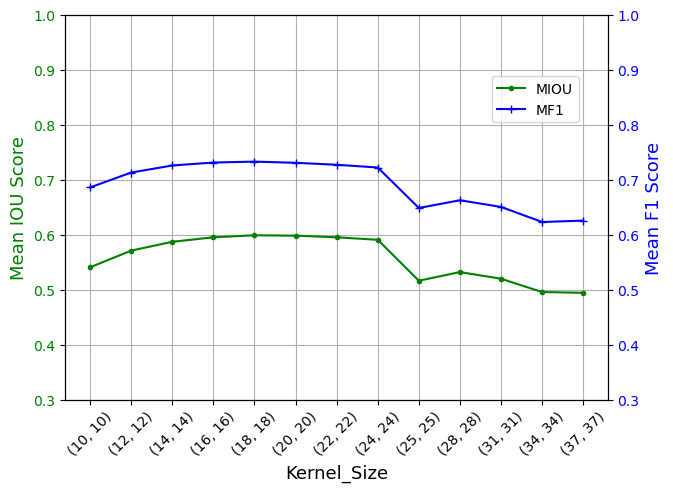

In [55]:
# Kernel metrics
kernel = grouper(metrics, 'mean_shape')
all_together(kernel, 'mean_shape', 'jaccard_mean', 'f1_mean', 0.3, 1, 0.3, 1)

C:\Users\User\AppData\Local\Temp\ipykernel_15568\2803492517.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])


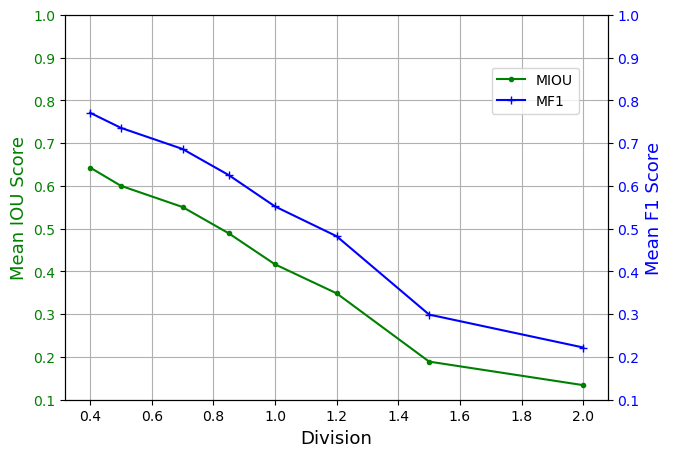

In [44]:
# Division metrics
div = grouper(metrics, 'division')
all_together(div, 'division', 'jaccard_mean', 'f1_mean', 0.1, 1, 0.1, 1)

C:\Users\User\AppData\Local\Temp\ipykernel_15568\2803492517.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])


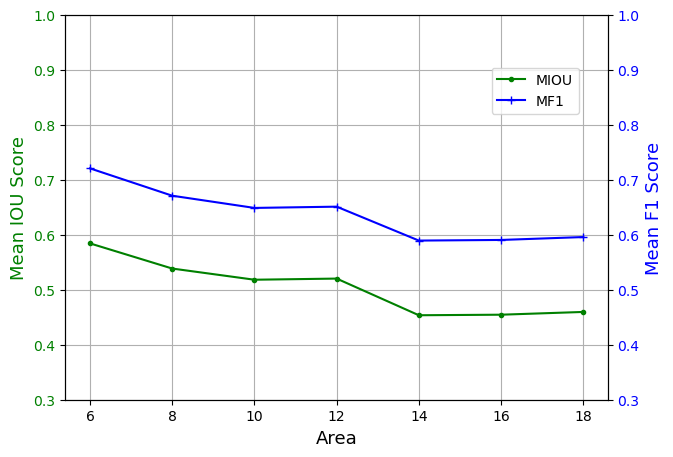

In [45]:
# Area metrics
are_a = grouper(metrics, 'area')
all_together(are_a, 'area', 'jaccard_mean', 'f1_mean')

C:\Users\User\AppData\Local\Temp\ipykernel_15568\2803492517.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])


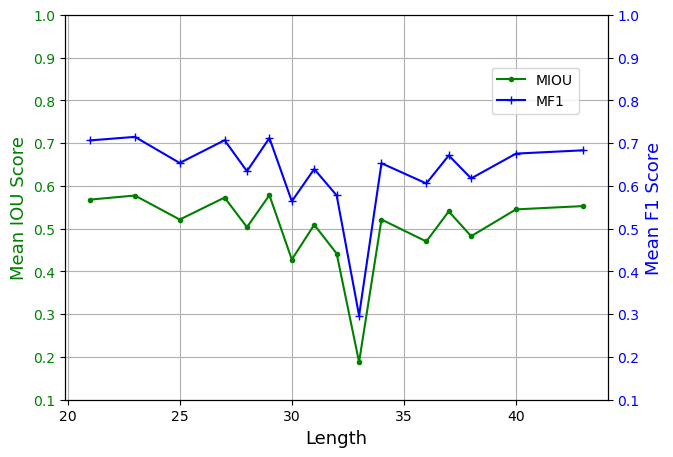

In [46]:
# length metrics
length = grouper(metrics, 'length')
all_together(length, 'length', 'jaccard_mean', 'f1_mean', 0.1, 1, 0.1, 1)

C:\Users\User\AppData\Local\Temp\ipykernel_15568\2803492517.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  results = df.copy().groupby(main_col)['jaccard', 'f1'].agg([np.mean, nth_fifth])


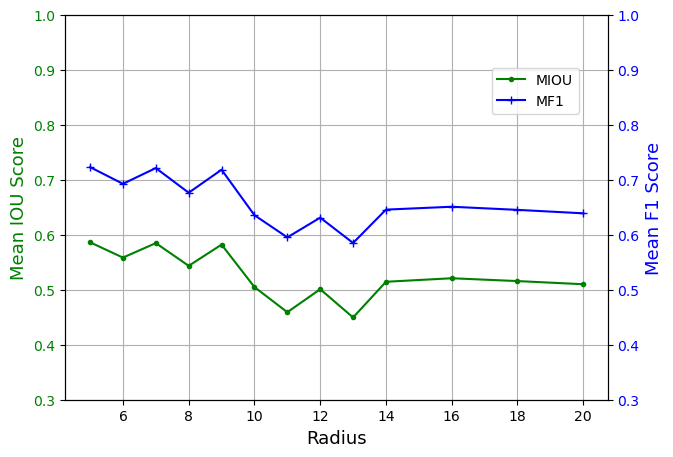

In [47]:
# Radius metrics
radi = grouper(metrics, 'radius')
all_together(radi, 'radius', 'jaccard_mean', 'f1_mean')

In [8]:
metrics

,pairs,image_name,mean_shape,division,area,length,radius,jaccard,f1,recall,precision,accuracy
0,"((10, 10), 0.4, 6, 21, 5)",Img10_m.jpg,"(10, 10)",0.4,6,21,5,0.449955,0.620647,0.451796,0.991022,0.984819
1,"((10, 10), 0.4, 6, 21, 5)",Img11_m.jpg,"(10, 10)",0.4,6,21,5,0.431049,0.602424,0.445551,0.929792,0.983394
2,"((10, 10), 0.4, 6, 21, 5)",Img12_m.jpg,"(10, 10)",0.4,6,21,5,0.626224,0.770157,0.644187,0.957370,0.992125
3,"((10, 10), 0.4, 6, 21, 5)",Img16_m.jpg,"(10, 10)",0.4,6,21,5,0.678428,0.808409,0.716949,0.926616,0.997494
4,"((10, 10), 0.4, 6, 21, 5)",Img17_m.jpg,"(10, 10)",0.4,6,21,5,0.639579,0.780174,0.696151,0.887265,0.997006
...,...,...,...,...,...,...,...,...,...,...,...,...
412095,"((37, 37), 1.2, 12, 43, 20)",Img_5.jpg,"(37, 37)",1.2,12,43,20,0.174312,0.296875,0.940476,0.176256,0.955562
412096,"((37, 37), 1.2, 12, 43, 20)",Img_6.jpg,"(37, 37)",1.2,12,43,20,0.149365,0.259908,0.974314,0.149955,0.940594
412097,"((37, 37), 1.2, 12, 43, 20)",Img_7.jpg,"(37, 37)",1.2,12,43,20,0.064594,0.121350,0.968065,0.064732,0.860075
412098,"((37, 37), 1.2, 12, 43, 20)",Img_8.jpg,"(37, 37)",1.2,12,43,20,0.049116,0.093634,0.951018,0.049241,0.819106


In [82]:
viz_skele = metrics.groupby(['mean_shape', 'area', 'radius', 'length'], as_index=False)['jaccard', 'f1'].agg([np.mean, nth_fifth])
viz_skele.reset_index(inplace=True)
viz_skele.columns = viz_skele.columns.get_level_values(0)
viz_skele.columns = ['mean_shape', 'area', 'radius', 'length', 'jaccard_mean', 'jaccard_95', 'f1_mean', 'f1_95']

C:\Users\User\AppData\Local\Temp\ipykernel_15568\2163685772.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  viz_skele = metrics.groupby(['mean_shape', 'area', 'radius', 'length'], as_index=False)['jaccard', 'f1'].agg([np.mean, nth_fifth])


In [83]:
viz_skele

,mean_shape,area,radius,length,jaccard_mean,jaccard_95,f1_mean,f1_95
0,"(10, 10)",6,5,21,0.536284,0.691141,0.682839,0.817367
1,"(10, 10)",6,5,23,0.538713,0.698718,0.684606,0.822642
2,"(10, 10)",6,5,25,0.542049,0.700348,0.687235,0.823770
3,"(10, 10)",6,5,27,0.542990,0.701455,0.688082,0.824536
4,"(10, 10)",6,5,29,0.544824,0.705015,0.689362,0.826990
...,...,...,...,...,...,...,...,...
1381,"(37, 37)",12,20,31,0.472339,0.751873,0.601466,0.858365
1382,"(37, 37)",12,20,34,0.482448,0.747425,0.611884,0.855459
1383,"(37, 37)",12,20,37,0.491629,0.752066,0.621291,0.858491
1384,"(37, 37)",12,20,40,0.501109,0.757679,0.630928,0.862136


In [84]:
def get_kern_num(kernel_shape):
    return int(kernel_shape.split(',')[0].replace('(', ''))

viz_skele['mean_shape'] = viz_skele['mean_shape'].apply(get_kern_num)

In [87]:
viz_skele_p = viz_skele[np.logical_and(viz_skele['mean_shape']<20, viz_skele['mean_shape']<20)]

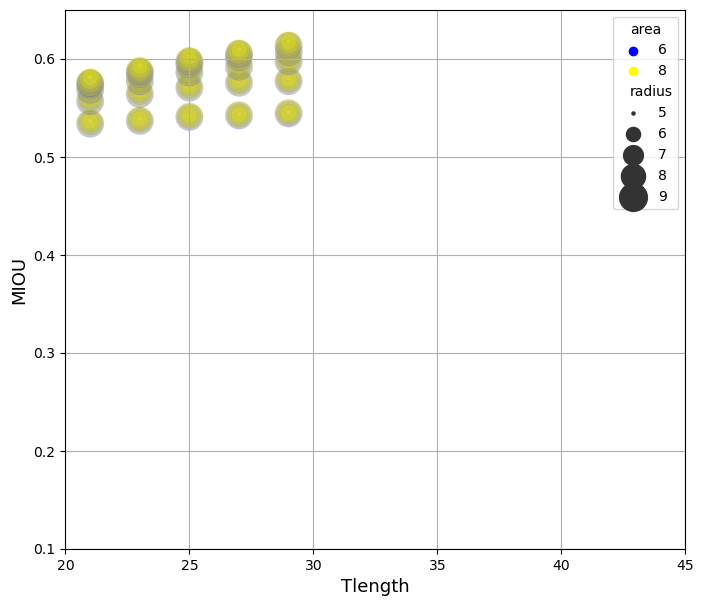

In [89]:
# Skele-Marker Compound Analysis, the one for CCELD was done already with 3d plots and file is in repo
palette = {6:'blue',8:'yellow',10:'green',12:'purple',14:'cyan',16:'black',18:'red'}
plt.figure(figsize= (8,7))

sns.scatterplot(x='length', y='jaccard_mean', size = 'radius', data = viz_skele_p, hue= 'area', 
                sizes = (5, 400), alpha= 0.3, palette = palette)
#plt.yticks(list(range(0, 1500, 50)))
#plt.title('Sensitivity Analysis Plot with Three Features and Power for Antarctica', fontsize= 15)
plt.ylabel('MIOU', fontsize = 13)
plt.xlabel('Tlength', fontsize = 13)
plt.ylim(0.1, 0.65)
plt.xlim(20, 45)
plt.grid()
plt.savefig('small_kernel.jpg', dpi= 300)

In [193]:
# Resizing all Images to take a square form
'''path = os.listdir('result_analysis')
for pt in path:
    img = cv2.imread('result_analysis/'+pt)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (800, 800))
    cv2.imwrite('result_analysis/'+pt+'_resized.jpg', img)'''

In [ ]:
# Results Analysis
# CDF for CCELD, Otsu, Skele, UNet

In [30]:
cdf_df=pd.DataFrame(columns=['number', 'probability'])
cdf=Cdf.from_seq([9,9.8,10,11,12])
cdf_df['number']=cdf.index
cdf_df['probability']=cdf.values

In [251]:
def get_cdf(metric='f1', df_list=[], algorithms=[], markers=[], colors=[]):
    for df, algo, marker,color in zip(df_list, algorithms, markers,colors):
        cdf=Cdf.from_seq(df[metric])
        cdf.plot(label=algo, marker=marker, markersize=5, color=color)
    plt.ylabel('Probability', fontsize=16)
    plt.xlabel(metric.capitalize(), fontsize=16)
    plt.legend() 
    #plt.grid()
    #plt.show()

In [239]:
# Loading the results
all_res = pd.read_csv('recent_results/All-Test-Results.csv')

otsu_ = all_res[all_res['algorithm']=='Otsu']
cceld_ = all_res[all_res['algorithm']=='CCELD']
skele_ = all_res[all_res['algorithm']=='CCELD + SKELE']
Unet = all_res[all_res['algorithm']=='UNet']
Unet_poor = all_res[all_res['algorithm']=='UNet Poor Training']

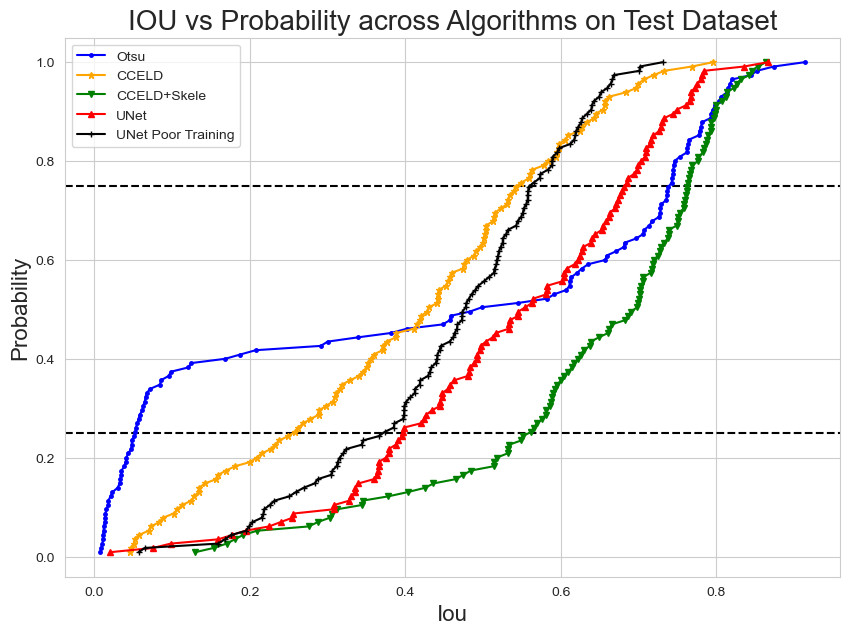

In [256]:
plt.figure(figsize=(10,7))
plt.axhline(y=0.25, color='k', linestyle='--')
plt.axhline(y=0.75, color='k', linestyle='--')
plt.title('IOU vs Probability across Algorithms on Test Dataset', fontsize=20)
get_cdf(metric='iou', df_list=[otsu_, cceld_, skele_, Unet, Unet_poor],
        algorithms=['Otsu', 'CCELD', 'CCELD+Skele', 'UNet', 'UNet Poor Training'],
        colors = ['blue', 'orange', 'green', 'red', 'k'],
        markers=['.', '*', 'v', '^', '+'])
plt.savefig('CDF_iou.jpg', dpi=1000, bbox_inches='tight')

In [1]:
all_res.algorithm.unique()

NameError: name 'all_res' is not defined

In [257]:
palette = {'Otsu':'blue', 'CCELD':'orange', 'CCELD + SKELE':'green', 'UNet':'red', 'UNet Poor Training':'k'}

C:\Users\User\AppData\Local\Temp\ipykernel_15796\1704315900.py:4: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax=sns.catplot(x='algorithm', y='recall', data=all_res, kind='swarm', height=5, aspect=1.5, palette=palette, size=4)


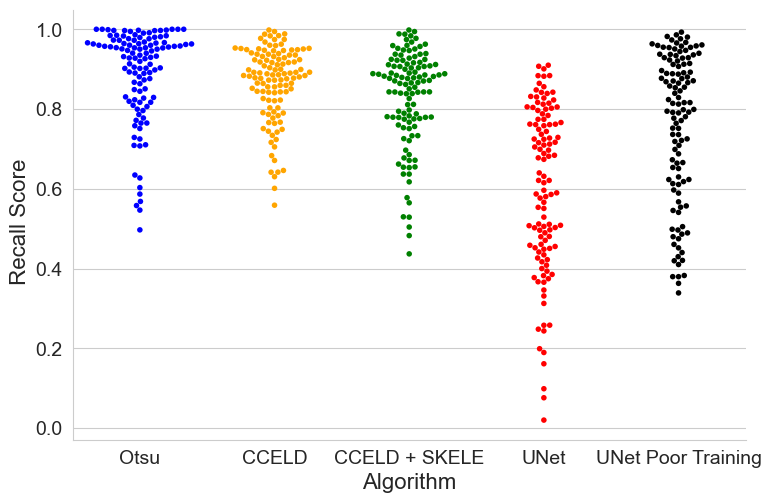

In [264]:
# Seems a swarmplot will be better so I ended up using a swarmplot

sns.set_style('whitegrid')
ax=sns.catplot(x='algorithm', y='recall', data=all_res, kind='swarm', height=5, aspect=1.5, palette=palette, size=4)
ax.tick_params(labelsize=14, axis = 'both')
#ax.set_xticklabels(['(', '(5x5)', '(10x10)'])
#plt.title('F1 Score distribution across Algorithms on Test Images', fontsize=20)
plt.xlabel('Algorithm', fontsize=16)
plt.ylabel(' Recall Score', fontsize=16)
#plt.ylim(0.3,1)
#plt.axhline(ker_2_25_f1, 0, 0.3, color='k', linestyle='--')
#plt.axhline(ker_2_75_f1, 0, 0.3, color = 'k', linestyle='--')
#plt.axhline(ker_5_25_f1, 0.35, 0.65, color='k', linestyle='--')
#plt.axhline(ker_5_75_f1, 0.35, 0.65, color='k',  linestyle='--')
#plt.axhline(ker_10_25_f1, 0.7, 1, color='k', linestyle='--')
#plt.axhline(ker_10_75_f1, 0.7, 1, color='k',  linestyle='--')
#plt.savefig('recall_swarmm_plot.jpg', dpi=2000, bbox_inches='tight')


## OTSU VS CCELD

In [2]:
im=cv2.imread('Img_15_col.jpg')

# Convert the images to grayscale
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
thre, otsu = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)

In [3]:
thre

123.0

In [233]:
# The point of this was to reverse the result (I wanted crack as white and background as black)
zr = np.zeros_like(im)
zr[im <= thre] = 255

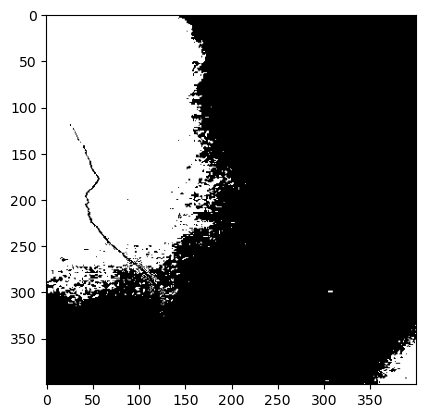

In [4]:
plt.imshow(otsu, cmap='gray')

In [235]:
#cv2.imwrite('otsu_15.jpg', zr)

True

## CNN Analysis

In [223]:
# DataFrame for storing CNN training results
cnn_data = pd.read_csv('recent_results/all_cnn_epoch_lr.csv')

# Convert string representation of tuple to actual tuple
cnn_data['params'] = cnn_data['params'].apply(ast.literal_eval)

In [224]:
cnn_data

,model_description,learning rate,Epochs,params
0,400 training on well labelled images,0.0100,25,"{'loss': [0.4538753628730774, 0.43020084500312..."
1,400 training on well labelled images,0.0010,25,"{'loss': [1.0817147493362427, 0.97992789745330..."
2,400 training on well labelled images,0.0050,25,"{'loss': [0.444957971572876, 0.426517784595489..."
3,400 training on well labelled images,0.0030,25,"{'loss': [0.5252126455307007, 0.43239188194274..."
4,400 training on well labelled images,0.0001,25,"{'loss': [1.4995248317718506, 1.45551693439483..."


In [225]:
def get_train_loss(val):
    return val['loss']

def get_val_loss(val):
    return val['val_loss']

def get_train_iou(val):
    return val['iou_score']

def get_val_iou(val):
    return val['val_iou_score']

In [226]:
# Creating a df that will house all metrics
new_df=pd.DataFrame(columns=['learning_rate', 'epoch', 'train_loss', 'train_iou', 'val_loss', 'val_iou'])

train_loss=[]
train_iou=[]
val_loss=[]
val_iou=[]

learning_rate=[]
epoch_=[]
lr=cnn_data['learning rate']

# Packing all functions and empty lists into a list to be used in loop
metrics=[get_train_loss, get_train_iou, get_val_loss, get_val_iou]
stores = [train_loss, train_iou, val_loss, val_iou]

In [227]:
# Range of 5 because I have 5 sets of learning rates I tested and I basically need 0-4 to slice in the codes below
for val in range(2):
    # The idea here is to add all learning rate 25 times into a single list
    for lr_rt in range(25):
        learning_rate.append(lr[val])
        epoch_.append(lr_rt+1)
    # Here I am looping through the metric functions and applying it on the dictionary cnn['params'] andI am looping 
    # the extracted list from the dictionary and adding each value to the store
    for metric, store in zip(metrics, stores):
        for sc in cnn_data['params'].apply(metric).iloc[val]:
            store.append(sc)

In [228]:
new_df['learning_rate']=learning_rate
new_df['epoch']=epoch_
new_df['train_loss']=train_loss
new_df['train_iou']=train_iou
new_df['val_loss']=val_loss
new_df['val_iou']=val_iou

In [229]:
# Saving
#new_df.to_csv('revamped-cnn-results-all.csv', index=False)

# reloading saved csv and removed 0.005 as it was affecting validation results
new_df=pd.read_csv('revamped-cnn-results.csv')

In [230]:
#cnn_data['params'].apply(get_loss).iloc[0]

In [233]:
#cnn_palette = {0.0001:'red', 0.003:'blue', 0.005:'green', 0.01:'orange', 0.001:'black'}
cnn_palette = {0.0001:'red', 0.003:'blue', 0.01:'orange', 0.001:'black'}

# Used to test poorly labelled results to know best lr also
#cnn_palette = {0.0001:'red',0.01:'orange'}

Text(0.5, 1.0, 'Epoch vs Training Loss on CNN')

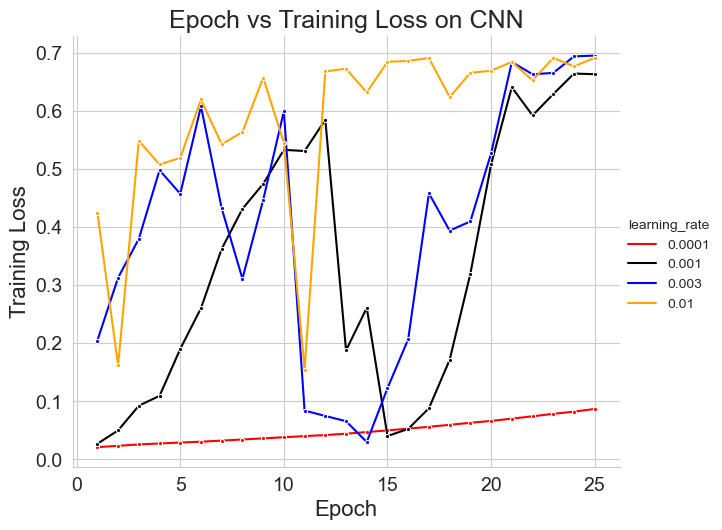

In [234]:
# 1. Line plot comparing all epochs
sns.set_style('whitegrid')
ax=sns.relplot(x='epoch', y='val_iou', data=new_df, kind='line', hue='learning_rate',height=5, aspect=1.25, marker='.',
      palette=cnn_palette)
ax.tick_params(labelsize=14, axis = 'both')
#ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Training Loss', fontsize=16)
#plt.ylim(0.1,2)
plt.title('Epoch vs Training Loss on CNN', fontsize=18)
#plt.savefig('train_loss.jpg', dpi=2000, bbox_inches='tight')


In [4]:
cnn_res.loc[len(cnn_res)]= [0.001, 20, '{/'loss/': [0.6384429931640625,
  0.5884855389595032,
  0.5485489368438721,
  0.520881175994873,
  0.4991268217563629,
  0.47988224029541016,
  0.4610722064971924,
  0.44220367074012756,
  0.43020498752593994,
  0.4094250500202179,
  0.40364888310432434,
  0.3855017125606537,
  0.37015587091445923,
  0.3598782420158386,
  0.35343796014785767,
  0.34091320633888245,
  0.33298924565315247,
  0.30997663736343384,
  0.30154168605804443,
  0.29652249813079834],
 /'iou_score/': [0.4744186997413635,
  0.5157204270362854,
  0.547968864440918,
  0.5705304741859436,
  0.58814537525177,
  0.6043610572814941,
  0.6188835501670837,
  0.6347367763519287,
  0.6444120407104492,
  0.6613906621932983,
  0.6662200093269348,
  0.6807148456573486,
  0.6931500434875488,
  0.701399028301239,
  0.7064760327339172,
  0.7170817255973816,
  0.7238863110542297,
  0.7409144639968872,
  0.7487419247627258,
  0.7532702684402466],
 /'val_loss/': [0.8971756100654602,
  1.0014152526855469,
  0.7505574226379395,
  0.7094440460205078,
  0.6688084602355957,
  0.6446931958198547,
  0.6625330448150635,
  0.6352975964546204,
  0.7092812061309814,
  0.6328149437904358,
  0.621835470199585,
  0.7634939551353455,
  0.6052550077438354,
  0.6465598344802856,
  0.6114771962165833,
  0.6145499348640442,
  0.7188879251480103,
  0.5660673379898071,
  0.5526666045188904,
  0.5733689069747925],
 /'val_iou_score/': [0.1654747873544693,
  0.1291486620903015,
  0.29107603430747986,
  0.32903850078582764,
  0.360547810792923,
  0.3815959393978119,
  0.3693477213382721,
  0.3970881402492523,
  0.33932721614837646,
  0.40294185280799866,
  0.4153808355331421,
  0.30783846974372864,
  0.42982903122901917,
  0.39691483974456787,
  0.42033615708351135,
  0.4284738600254059,
  0.34105774760246277,
  0.4666796624660492,
  0.4787960946559906,
  0.4607279300689697],
 /'lr/': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.000100000005,
  0.000100000005,
  0.000100000005]}"]


SyntaxError: unterminated string literal (detected at line 1) (1377677257.py, line 1)

## Discoveries
White edges near Cracks: What's happening is that near the crack itself, the non crack pixels are having a high absolute difference because the mean is small compared to their values because part of the mean kernel is entering the crack (dark or low pixel value region) and part is not in the crack (light or high pixel value region). They basically have a high value after doing a subtraction. For example in the test image we see 

Gray Image [186 188 190 191 192 193 193 191 187 183 178 173 169 164 160 156 153 151
 151 155 163 171 181 188 194 195 192 193 199 198 192 174 146 125 109 104
 111 119 126 134]
 
Mean Image [178 180 182 183 184 184 183 182 181 179 177 174 171 168 165 163 161 162
 163 165 169 172 177 181 186 190 192 191 187 179 170 161 151 143 135 128
 123 121 122 125]
 
Image difference [ 7  8  7  8  8  8  9  8  6  3  1  1  2  3  4  6  7 10 10  8  6  0  3  7
  6  4  2  4 10 17 18  9  3 17 23 21 13  3  4  9]
  
Crack mask Image [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 255 255   0   0 255 255 255
 255   0   0   0]
 
segmented Image [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0 198 192   0   0 125 109 104
 111   0   0   0]
* Test: Take difference and not absolute difference.
* Test: Do another thresholding and set white pixels to 0.
* Outcome: 

2. This approach in the real sense should have different thresholds for different images. I have to find a way to get a sense of the image distribution to know if the image is a generally dark or light image. If it's generally dark, I might consider a lesser threshold so as to activate the cracks more.

3. In an image with a light and a dark color and a crack is in both parts of the image, since we consider one threshold, it’s usually not sufficient to segment cracks in both parts of the image.

In [ ]:
'''# Ground truth
test_mask_png = io.imread("labels_as_png/task-9-annotation-6-by-1-tag-Roads-0.png")
plt.imshow(test_mask_png, cmap='gray')
print(np.unique(test_mask_png))  #This is not a true binary image.

#Let us load a numpy array saved from Label Studio
test_mask_np = np.load("labels_as_numpy/task-9-annotation-6-by-1-tag-Roads-0.npy")
plt.imshow(test_mask_np, cmap='gray')
print(np.unique(test_mask_np)) #This is not a true binary image.

#Need to binarize the image. Simple thresholding for values above 0. 
#Convert all values above 0 to 1 to assign a pixel value of 1 for the Houses class.
#Similarly convert other values for other classes to 2, 3, etc. 
my_mask = np.where(test_mask_png>0, 1, test_mask_png)'''

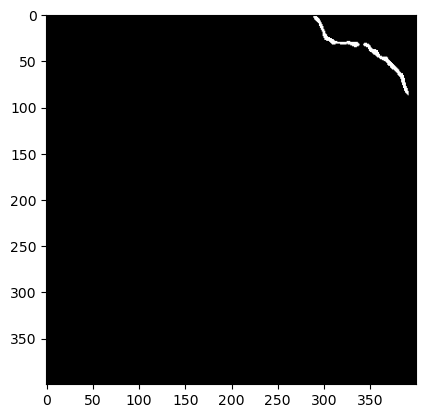

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io

def neighbours(x,y,image):
    "Return 8-neighbours of image point P1(x,y), in a clockwise order"
    img = image
    x_1, y_1, x1, y1 = x-1, y-1, x+1, y+1
    return [ img[x_1][y], img[x_1][y1], img[x][y1], img[x1][y1],     # P2,P3,P4,P5
                img[x1][y], img[x1][y_1], img[x][y_1], img[x_1][y_1] ]    # P6,P7,P8,P9

def transitions(neighbours):
    "No. of 0,1 patterns (transitions from 0 to 1) in the ordered sequence"
    n = neighbours + neighbours[0:1]      # P2, P3, ... , P8, P9, P2
    return sum( (n1, n2) == (0, 1) for n1, n2 in zip(n, n[1:]) )  # (P2,P3), (P3,P4), ... , (P8,P9), (P9,P2)

def zhangSuen(image):
    "the Zhang-Suen Thinning Algorithm"
    Image_Thinned = image.copy()  # deepcopy to protect the original image
    changing1 = changing2 = 1        #  the points to be removed (set as 0)
    while changing1 or changing2:   #  iterates until no further changes occur in the image
        # Step 1
        changing1 = []
        rows, columns = Image_Thinned.shape               # x for rows, y for columns
        for x in range(1, rows - 1):                     # No. of  rows
            for y in range(1, columns - 1):            # No. of columns
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1     and    # Condition 0: Point P1 in the object regions 
                    2 <= sum(n) <= 6   and    # Condition 1: 2<= N(P1) <= 6
                    transitions(n) == 1 and    # Condition 2: S(P1)=1  
                    P2 * P4 * P6 == 0  and    # Condition 3   
                    P4 * P6 * P8 == 0):         # Condition 4
                    changing1.append((x,y))
        for x, y in changing1: 
            Image_Thinned[x][y] = 0
        # Step 2
        changing2 = []
        for x in range(1, rows - 1):
            for y in range(1, columns - 1):
                P2,P3,P4,P5,P6,P7,P8,P9 = n = neighbours(x, y, Image_Thinned)
                if (Image_Thinned[x][y] == 1   and        # Condition 0
                    2 <= sum(n) <= 6  and       # Condition 1
                    transitions(n) == 1 and      # Condition 2
                    P2 * P4 * P8 == 0 and       # Condition 3
                    P2 * P6 * P8 == 0):            # Condition 4
                    changing2.append((x,y))    
        for x, y in changing2: 
            Image_Thinned[x][y] = 0
    return Image_Thinned
 



# Apply Zhang-Suen thinning algorithm
thinned_image = zhangSuen(selected_components)

plt.imshow(thinned_image, cmap='gray')


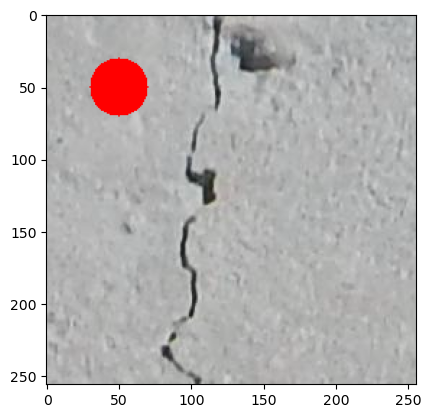

In [12]:
import cv2

# Load an image
image = cv2.imread('7004-28.jpg')

# Define the center coordinates and radius
center_coordinates = (10, 10)
radius = 10

# Define color and thickness
color = (0, 0, 255)  # Red in BGR
thickness = 2

# Draw the circle on the image
cv2.circle(image, (50, 50), 20, 255, -1)
#cv2.circle(image, center_coordinates, radius, color, thickness)

plt.imshow(image, cmap='gray')

In [ ]:
def imreconstruct(marker: np.ndarray, mask: np.ndarray, radius: int = 1):
    """Iteratively expand the markers while keeping them limited by the mask during each iteration.

    :param marker: Grayscale image where initial seed is white on black background.
    :param mask: Grayscale mask where the valid area is white on black background.
    :param radius Can be increased to improve expansion speed while causing decreased isolation from nearby areas.
    :returns A copy of the last expansion.
    Written By Semnodime.
    """
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    while True:
        expanded = cv2.dilate(src=marker, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=mask, dst=expanded)

        # Termination criterion: Expansion didn't change the image at all
        if (marker == expanded).all():
            return expanded
        marker = expanded

<a name="Gen_images"></a>
## Generating Images from the different CCELD Steps for Paper

In [27]:
#Resizing colored images
img_n = 'Img_103'

# Reading Images
path = 'Paper_Images_New/Top6'
image= cv2.imread(path+'/'+img_n+'.jpg')

image = cv2.resize(image, (400, 400))
#plt.imshow(image)
cv2.imwrite('Paper_Images_New/CCELD_Preprocess/Colored_Resized'+'/'+img_n+'_col.jpg', image)

True

In [242]:
# Contrast enhancement on 5 chosen Images

# Reading Images
path = 'Paper_Images_New/Top6'
img = 'Img23_m'
image= cv2.imread(path+'/'+img+'.jpg')

# Convert the images to grayscale
gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)

# Smooth the image to remove noise
smooth_image = cv2.blur(gray_image, (3, 3))

# Resizing both images
gray_image = cv2.resize(smooth_image, (400, 400))
#plt.imshow(gray_image, cmap='gray')
#plt.grid()
#plt.show()
#cv2.imwrite('Paper_Images_New/Gray/Img_2000_gray.jpg', gray_image)

# applying contrast and brightness enhancement
alpha = 1 # Simple contrast control
beta = 50   # Simple brightness control   
gray_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)
#plt.imshow(gray_image, cmap='gray')
#plt.grid()
#plt.show()
#cv2.imwrite('Paper_Images_New/Contrast_Enhanced/Img_2000_contrast.jpg', gray_image)


In [243]:
# Image blur extraction
mean_image = cv2.blur(gray_image, (31,31))

gray_image = gray_image.astype(np.int32)
mean_image = mean_image.astype(np.int32)

#cv2.imwrite('Paper_Images_New/Img_blur/Img_9_blur.jpg', mean_image)

In [244]:
# Image differencing extraction
std_image = gray_image - mean_image
#plt.imshow(std_image, cmap='gray')

'''# Create a sample 2D array (you can replace this with your data)
data = std_image[200:225, 185:210] # Example data (5x5 array of random values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,12))

# Plot the data as a heatmap with values displayed in each cell
cax = ax.matshow(data, cmap='gray')

# Add annotations (pixel values) to each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i, j]:}', va='center', ha='center', color='red', fontsize=12)

# Customize the plot (you can adjust this as needed)
#plt.colorbar(cax)
plt.title("2D Plot with Pixel Values")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
#plt.savefig('Paper_Images_New/Img_diff_pixel/Img_2000_pixel.jpg', dpi = 500, bbox_inches = 'tight')


# Display the plot
plt.show()'''

#cv2.imwrite('Paper_Images_New/Img_diff_pixel/Img_9_pixel.jpg', ax)

'# Create a sample 2D array (you can replace this with your data)\ndata = std_image[200:225, 185:210] # Example data (5x5 array of random values)\n\n# Create a figure and axis\nfig, ax = plt.subplots(figsize=(12,12))\n\n# Plot the data as a heatmap with values displayed in each cell\ncax = ax.matshow(data, cmap=\'gray\')\n\n# Add annotations (pixel values) to each cell\nfor i in range(data.shape[0]):\n    for j in range(data.shape[1]):\n        ax.text(j, i, f\'{data[i, j]:}\', va=\'center\', ha=\'center\', color=\'red\', fontsize=12)\n\n# Customize the plot (you can adjust this as needed)\n#plt.colorbar(cax)\nplt.title("2D Plot with Pixel Values")\nplt.xlabel("X-Axis")\nplt.ylabel("Y-Axis")\n#plt.savefig(\'Paper_Images_New/Img_diff_pixel/Img_2000_pixel.jpg\', dpi = 500, bbox_inches = \'tight\')\n\n\n# Display the plot\nplt.show()'

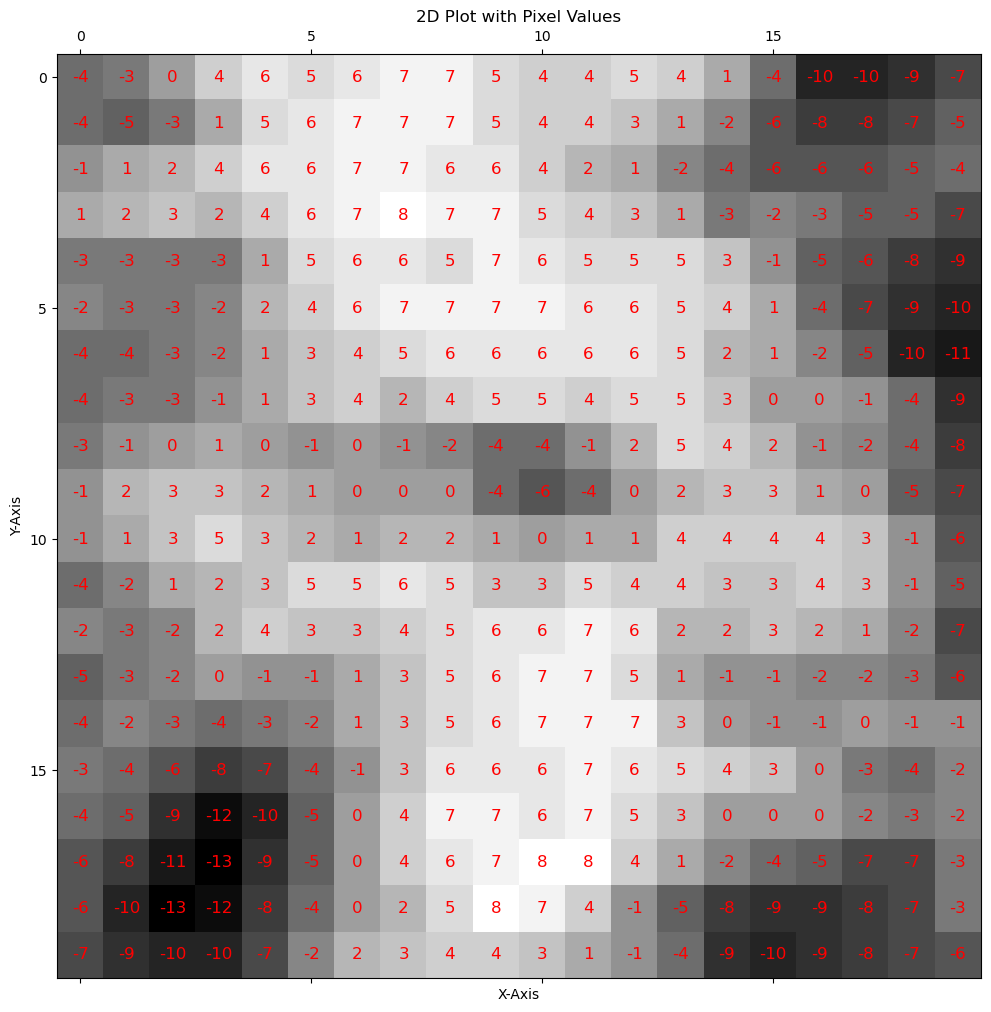

In [230]:
# Generating pixel values for crack regions

# Create a sample 2D array (you can replace this with your data)
data = std_image[100:120, 300:320] # Example data (5x5 array of random values)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12,12))

# Plot the data as a heatmap with values displayed in each cell
cax = ax.matshow(data, cmap='gray')

# Add annotations (pixel values) to each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, f'{data[i, j]:}', va='center', ha='center', color='red', fontsize=12)

# Customize the plot (you can adjust this as needed)
#plt.colorbar(cax)
plt.title("2D Plot with Pixel Values")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
#plt.savefig('Paper_Images_New/Img_pixels/Img_106_pix.jpg', dpi = 500, bbox_inches = 'tight')


# Display the plot
plt.show()

#cv2.imwrite('Paper_Images_New/Img_diff_pixel/Img_9_pixel.jpg', ax)

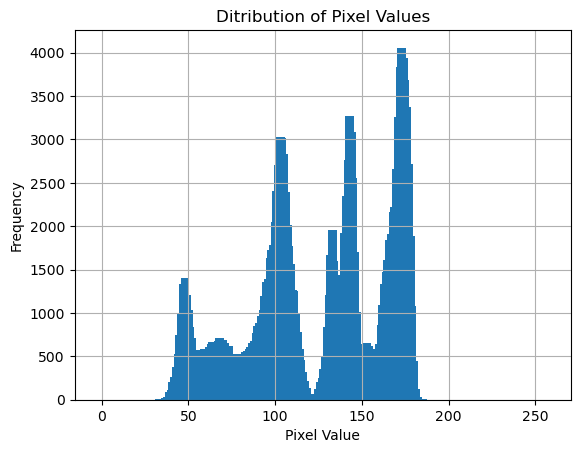

In [168]:
# Getting Histograms
hist = cv2.calcHist([gray_image],[0], None, [256], [0,256])

intensity_values = np.array([x for x in range(hist.shape[0])])
plt.bar(intensity_values, hist[:,0], width = 5)
plt.title("Ditribution of Pixel Values")
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid()
#plt.savefig('Paper_Images_New/Histogram/Img_2000_hist.jpg', dpi = 500, bbox_inches = 'tight')
plt.show()

# this is for the green wall near Cheta's class

In [245]:
# Automated threshold selection based on histogram distribution in gray image, basically if there's so much brightness in
# image we want to use a high threshold to activate the crack if not, we use a low threshold

# Calculating the average of the 25th, 50th, 75th, and 85th percentile pixel value
perc_25, perc_35, perc_45, perc_50, perc_65, perc_75  = np.percentile(smooth_image, 25), np.percentile(smooth_image, 35), \
np.percentile(smooth_image, 45), np.percentile(smooth_image, 50), np.percentile(smooth_image, 65), np.percentile(smooth_image, 75)

# Calculating average of the 1th, 1.2th and 1.5th percentiles
perc_1, perc_1p2, perc_1p5 = np.percentile(smooth_image, 1), np.percentile(smooth_image, 1.2), \
np.percentile(smooth_image, 1.5)

low_mean = np.mean([perc_1, perc_1p2, perc_1p5])
high_mean = np.mean([perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
join_mean = np.mean([perc_1, perc_1p2, perc_1p5, perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])

diff = high_mean - low_mean
threshold = join_mean - low_mean
#ratio = low_mean/high_mean

threshold = (np.sqrt(threshold)/0.4)*-1
# print(threshold)
#print('Your threshold is {}'.format(threshold))

# Create a binary mask where cracks are represented as white pixels
crack_mask = np.zeros_like(std_image)
crack_mask[std_image <= threshold] = 255

# Apply the crack mask to the original image
gray_image = gray_image.astype(np.uint8)
crack_mask = crack_mask.astype(np.uint8)
cv2.imwrite('Paper_Images_New/CCELD/'+img+'_cceld.jpg', crack_mask)
#plt.imshow(sk_crack_mask, cmap='gray')
#plt.show()
#segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=crack_mask)

# Applying Skele-Marker
# 1. Area thresholding on crack image
sk_crack_mask = apply_area_thresholding(crack_mask, 12)
#plt.imshow(sk_crack_mask, cmap='gray')
cv2.imwrite('Paper_Images_New/Area_Thresh/'+img+'_areathresh.jpg', sk_crack_mask)


# 2. Thinning and using Tlength
thinned_image = cv2.ximgproc.thinning(sk_crack_mask)
cv2.imwrite('Paper_Images_New/Skeleton/'+img+'_skele.jpg', thinned_image)


# 3. Remove small skeletons
thinned_image = remove_small_skeletons(thinned_image, 43)
#plt.imshow(thinned_image_1)
cv2.imwrite('Paper_Images_New/Thin/'+img+'_thinned.jpg', thinned_image*255)

# 4. Morph Reconstruct1
restored_image = restore_skeletons(sk_crack_mask, thinned_image)
cv2.imwrite('Paper_Images_New/Morph_Reconstruct1/'+img+'_recon.jpg', restored_image*255)

# 5. Get circles
circle = get_circle(thinned_image, sk_crack_mask, Tradius = 18)
cv2.imwrite('Paper_Images_New/Circles/'+img+'_circle.jpg', circle)

# 6. Using Radius restoration
rad = implement_radius_restoration(thinned_image, sk_crack_mask, Tradius = 18)
cv2.imwrite('Paper_Images_New/Radius_Restore/'+img+'_rad_restore.jpg', rad)

# 7. Combining remaining skeleton with radius based on endpoint restoration
sk_crack_mask = cv2.bitwise_or(restored_image*255, rad)
cv2.imwrite('Paper_Images_New/Final_Output/'+img+'_end.jpg', sk_crack_mask)

'''
# Displaying Results
plt.figure(figsize=(9,7))
plt.subplot(1,3,1)
plt.imshow(groud_truth_img, cmap='gray')
plt.title('Ground Truth')
plt.subplot(1,3,2)
plt.imshow(crack_mask, cmap='gray')
plt.title('CCELD Mask')
plt.subplot(1,3,3)
plt.imshow(sk_crack_mask, cmap='gray')
plt.title('CCELD + SKELE-MARKER Mask')
plt.grid()
plt.show()'''

"\n# Displaying Results\nplt.figure(figsize=(9,7))\nplt.subplot(1,3,1)\nplt.imshow(groud_truth_img, cmap='gray')\nplt.title('Ground Truth')\nplt.subplot(1,3,2)\nplt.imshow(crack_mask, cmap='gray')\nplt.title('CCELD Mask')\nplt.subplot(1,3,3)\nplt.imshow(sk_crack_mask, cmap='gray')\nplt.title('CCELD + SKELE-MARKER Mask')\nplt.grid()\nplt.show()"

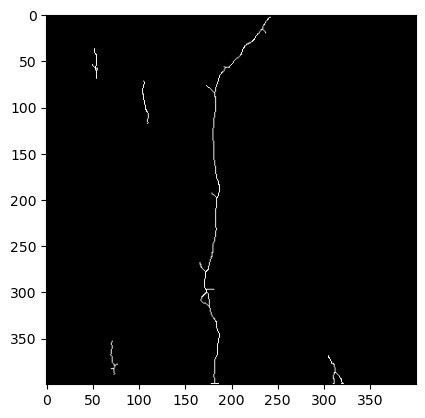

In [218]:
## CCELD + SKELE Images
thinned_image = remove_small_skeletons(thinned_image, 43)
plt.imshow(thinned_image, cmap='gray')

[(3, 242), (20, 237), (37, 52), (54, 50), (56, 192), (69, 54), (72, 105), (77, 173), (118, 109), (193, 179), (268, 166), (297, 181), (353, 71), (369, 305), (378, 77), (383, 70), (389, 73)]


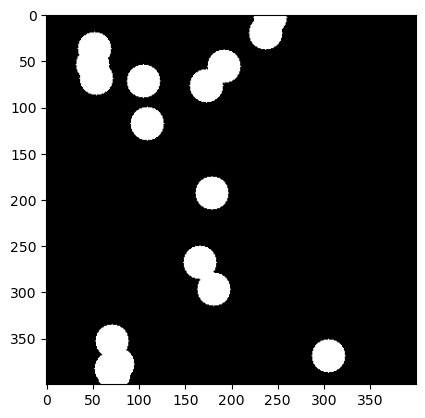

In [2]:
import cv2
import numpy as np

def extract_frames(video_path, output_path):
    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the video
    fps = video.get(cv2.CAP_PROP_FPS)
    # print(fps)

    # Initialize frame counter and time
    frame_count = 0
    time = 0

    while True:
        # Read a frame from the video
        ret, frame = video.read()
        # print(ret)

        # If frame was not successfully read, end the loop
        if not ret:
            break

        # Calculate the time in seconds
        time = frame_count / fps
        # print(int(time))

        # Check if the current frame's time is a multiple of 1 second
        if int(time) % 1 == 0:
            # Write the frame to an image file
            frame_output_path = f"{output_path}/frame_{int(time)}.jpg"
            cv2.imwrite(frame_output_path, frame)

        # Increment the frame counter
        frame_count += 10
        # print('Frame')

    # Release the video file
    video.release()

#def frame_to_video(folder_path):
    # Sorting the frames in

def apply_area_thresholding(crack_mask, Tarea=10):
    # Find connected components and their stats (including area)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(crack_mask, connectivity=8)

    # Define a minimum area threshold to remove small objects (adjust this value as needed)
    min_area_threshold = Tarea  # Adjust this threshold as needed

    # Create a mask to store the selected components
    selected_components = np.zeros_like(crack_mask)

    # Iterate through connected components
    for label in range(1, num_labels):
        # Check the area of the current component
        area = stats[label, cv2.CC_STAT_AREA]
        #print(area)

        # If the area is greater than or equal to the threshold, include it in the selected components
        if area >= min_area_threshold:
            selected_components[labels == label] = 255  # Set pixels to 255 (white)

    return selected_components

def find_endpoints(thinned_image):
    endpoints = []
    height, width = thinned_image.shape

    # We loop from (1,1) so that each pixel will have eight neighbours (0,0) is the edge
    for x in range(1, height - 1):
        for y in range(1, width - 1):
            if thinned_image[x, y] == 1:  # Check if it's a white pixel (part of skeleton)
                # Define a neighborhood of 8 pixels around the current pixel
                neighborhood = thinned_image[x-1:x+2, y-1:y+2]

                # Count the number of non-zero (white) pixels in the neighborhood
                white_pixel_count = np.count_nonzero(neighborhood)
                #print(white_pixel_count)

                # If there's only one white pixel in the neighborhood, it's an endpoint
                if white_pixel_count == 2:#
                    endpoints.append((x, y))
    return endpoints

# Step 5: Length Threshold
def remove_small_skeletons(thinned_image, Tlength): 
    _, labels = cv2.connectedComponents(thinned_image)
    
    # The number of labels is max label + 1 since we do 0 indexing
    num_labels = labels.max() + 1
    
    # We create a list to store the skeletons or say the skeleton images where the >= Tlength condition is satisfied
    skeletons = []

    for label in range(1, num_labels):  # Exclude background (label 0)
        # We loop through all the labels and the variable "component" just creates an image where only pixels from a 
        # Particular label is shown
        component = (labels == label).astype(np.uint8)
        #print(component.shape)
        
        
        # Below after getting all pixels from each label, we sum the pixels from the labels and use basically if the sum 
        # of the skeleton from a particular label is small, we take it as noise which makes a whole lot of sense.
        if np.sum(component) >= Tlength:
            skeletons.append(component)

    # Create a new thinned image with the remaining skeletons - we basically join all the skeletons in the skeleton list
    # The skeleton list is where we kept the pixels with long lengths
    thinned_image = np.zeros_like(thinned_image)
    for skeleton in skeletons:
        thinned_image |= skeleton  # Use logical OR to combine skeletons

    return thinned_image

def implement_radius_restoration(tlength_applied_thin_img, original_image, Tradius= 20):   
    endpoints = find_endpoints(tlength_applied_thin_img)
    #print(endpoints)

    for endpoint in endpoints:
        x, y = endpoint[1], endpoint[0]
        mask = np.zeros_like(original_image)
        cv2.circle(mask, (x, y), Tradius, 255, -1)
        #plt.imshow(mask, cmap='gray')
        #plt.show()
    # Restore pixels in the thinned image using the mask
        tlength_applied_thin_img = np.maximum(tlength_applied_thin_img, cv2.bitwise_and(original_image, mask)) 
        
    return tlength_applied_thin_img

# Basically, this part is to restore the skeletons based after using tlength to remove stuff. The idea is to use dilation with
# a kernel which tells how much pixels to add basically to grow back pixels in the skeleton from the original image. 
# We then use bitwise and which returns 1 if both pictures are 1 and 1. What we're doing is that with dilation, 
# we're growing pixels but we want to keep only pixels based on their presence in out dirty image.
def restore_skeletons(original_image, thinned_image, radius = 1):   
    # Dilation process
    kernel = np.ones(shape=(radius * 2 + 1,) * 2, dtype=np.uint8)
    
    # Here, we're basically doing dilation on the thinned image after that, we do the bitwise and on the dilated result and mask
    # and update the variable "expanded", thinned image on first iteration is still the skeleton but then we check if the 
    # thinned image == expanded(i.e dilated+mask) we then update thinned to be = expanded. We do a dilation on the new updated
    # thinned which takes the variable expanded, we then use bitwise_and on dilation 2 and original image and update expanded.
    # Now, thinned is first comparison of dilation and mask the idea is we want to stop when the result of a previous 
    # dilation and mask operation if it's the same as the current dilation and mask bitwise operation
    while True:
        expanded = cv2.dilate(src=thinned_image, kernel=kernel)
        cv2.bitwise_and(src1=expanded, src2=original_image, dst=expanded)

        # Termination criterion: Expansion didn't change the image at all
        if (thinned_image == expanded).all():
            return expanded
        thinned_image = expanded
        

def Pipeline (image, kernel = (31,31), div=0.4, Tarea = 12, Tlength = 43, Tradius = 18):
    # Convert the images to grayscale
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    
    # Smooth the image to remove noise
    smooth_image = cv2.blur(gray_image, (3, 3))
    
    # Resizing both images
    gray_image = cv2.resize(smooth_image, (400, 400))

    # applying contrast and brightness enhancement
    alpha = 1 # Simple contrast control
    beta = 50   # Simple brightness control   
    gray_image = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    # Calculate the mean and standard deviation of the pixel values using a 3x3 neighborhood
    mean_image = cv2.blur(gray_image, kernel)

    gray_image = gray_image.astype(np.int32)
    mean_image = mean_image.astype(np.int32)

    std_image = gray_image - mean_image

    # Automated threshold selection based on histogram distribution in gray image, basically if there's so much brightness in
    # image we want to use a high threshold to activate the crack if not, we use a low threshold

    # Calculating the average of the 25th, 50th, 75th, and 85th percentile pixel value
    perc_25, perc_35, perc_45, perc_50, perc_65, perc_75  = np.percentile(smooth_image, 25), np.percentile(smooth_image, 35), \
    np.percentile(smooth_image, 45), np.percentile(smooth_image, 50), np.percentile(smooth_image, 65), np.percentile(smooth_image, 75)

    # Calculating average of the 1th, 1.2th and 1.5th percentiles
    perc_1, perc_1p2, perc_1p5 = np.percentile(smooth_image, 1), np.percentile(smooth_image, 1.2), \
    np.percentile(smooth_image, 1.5)

    low_mean = np.mean([perc_1, perc_1p2, perc_1p5])
    high_mean = np.mean([perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
    join_mean = np.mean([perc_1, perc_1p2, perc_1p5, perc_25, perc_35, perc_45, perc_50, perc_65, perc_75])
    
    diff = high_mean - low_mean
    threshold = join_mean - low_mean
    #ratio = low_mean/high_mean
    
    threshold = (np.sqrt(threshold)/div)*-1
    # print(threshold)
    #print('Your threshold is {}'.format(threshold))
    
    # Create a binary mask where cracks are represented as white pixels
    crack_mask = np.zeros_like(std_image)
    crack_mask[std_image <= threshold] = 255

    # Apply the crack mask to the original image
    gray_image = gray_image.astype(np.uint8)
    crack_mask = crack_mask.astype(np.uint8)
    #segmented_image = cv2.bitwise_and(gray_image, gray_image, mask=crack_mask)
    
    # Applying Skele-Marker
    # 1. Area thresholding on crack image
    sk_crack_mask = apply_area_thresholding(crack_mask, Tarea)
    
    # 2. Thinning and using Tlength
    thinned_image = cv2.ximgproc.thinning(sk_crack_mask)
    
    # 3. Remove small skeletons
    thinned_image = remove_small_skeletons(thinned_image, Tlength)

    # 4. Restore skeletons
    restored_image = restore_skeletons(sk_crack_mask, thinned_image)

    # 5. Using Radius restoration
    rad = implement_radius_restoration(thinned_image, sk_crack_mask, Tradius = Tradius)
    
    # Combining remaining skeleton with radius based on endpoint restoration
    sk_crack_mask = cv2.bitwise_or(restored_image*255, rad)
    
    return sk_crack_mask


In [14]:
#Resizing colored images
img_n = 'Img_103'

# Reading Images
path = 'Paper_Images_New/Top6'
image= cv2.imread(path+'/'+img_n+'.jpg')

im = Pipeline(image)

im = cv2.resize(im, (400, 400))
#plt.imshow(image)
cv2.imwrite('Paper_Images_New/CCELD_Skele_out'+'/'+img_n+'_out.jpg', im)

True